In [1]:
import numpy as np
import pandas as pd
import SolveLinSys
import matplotlib.pyplot as plt
from numba import njit

import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
from scipy.interpolate import interp2d
from solver_2d import false_transient_one_iteration_python
from derivative import derivatives_2d

In [2]:
@njit
def compute_derivatives(data, dim, order, dlt):
    res = np.zeros_like(data)
    if order == 1:                    # first order derivatives
        if dim == 0:                  # to first dimension
            res[1:,:] = (1 / dlt) * (data[1:,:] - data[:-1,:])
            res[0,:] = (1 / dlt) * (data[1,:] - data[0,:])
        elif dim == 1:                # to second dimension
            res[:,1:] = (1 / dlt) * (data[:,1:] - data[:,:-1])
            res[:,0] = (1 / dlt) * (data[:,1] - data[:,0])        
    elif order == 2:
        if dim == 0:                  # to first dimension
            res[1:-1,:] = (1 / dlt ** 2) * (data[2:,:] + data[:-2,:] - 2 * data[1:-1,:])
            res[-1,:] = (1 / dlt ** 2) * (data[-1,:] + data[-3,:] - 2 * data[-2,:])
            res[0,:] = (1 / dlt ** 2) * (data[2,:] + data[0,:] - 2 * data[1,:])
        elif dim == 1:                # to second dimension
            res[:,1:-1] = (1 / dlt ** 2) * (data[:,2:] + data[:,:-2] - 2 * data[:,1:-1])
            res[:,-1] = (1 / dlt ** 2) * (data[:,-1] + data[:,-3] - 2 * data[:,-2])
            res[:,0] = (1 / dlt ** 2) * (data[:,2] + data[:,0] - 2 * data[:,1])    
    return res

def false_transient_one_iteration(stateSpace, A, B1, B2, C1, C2, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B1.reshape(-1, 1, order='F'), B2.reshape(-1, 1, order='F')])
    C = np.hstack([C1.reshape(-1, 1, order='F'), C2.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

PDE:
\begin{align*}
0 = \max_{\mathcal{E}}  &  -\delta \phi(y_1, y_2) + \eta \log \mathcal{E} \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} (-\lambda y_2 + \lambda \sum_{i=1}^m \pi^p_i \theta_i \mathcal{E})\\
&+ \frac{\eta-1}{\delta}\left[\gamma_1 + \gamma_2 y_1 + \gamma_2^+\boldsymbol{1}_{y_1\geq \bar{y}_1}(y_1-\bar{y}_1)\right]y_2\\
&+ \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)
\end{align*}

FOC of $\mathcal{E}$ gives:
$$
\mathcal{E} = -\frac{\eta}{\frac{\partial \phi}{\partial y_2} \lambda \sum_{i=1}^m \pi^d_i \theta_i}
$$

In [3]:
def false_transient(y1_grid, y2_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, γ_1, γ_2, γ_2p, y_bar, πc_o, ξ_a, λ = model_paras
    dy1 = y1_grid[1] - y1_grid[0]
    dy2 = y2_grid[1] - y2_grid[0]
    (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
    stateSpace = np.hstack([y1_mat.reshape(-1, 1, order='F'), y2_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -η*(y1_mat+y2_mat+(y1_mat+y2_mat)**2)
    e_tilde = np.array(0)

    d_Λ = γ_1 + γ_2*y1_mat + γ_2p*(y1_mat>y_bar)*(y1_mat-y_bar)

    πc = np.ones((len(πc_o), len(y1_grid), len(y2_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde.copy()

        v0_dy1 = compute_derivatives(v0, 0, 1, dy1)
        v0_dy2 = compute_derivatives(v0, 1, 1, dy2)        
#         v0_dy1 = derivatives_2d(v0, 0, 1, dy1)
#         v0_dy2 = derivatives_2d(v0, 1, 1, dy2)          
        
        e_tilde = -η/(v0_dy2*λ*np.sum(πc*θ, axis=0))
        e_tilde[e_tilde<=0] = 1e-15
        e_tilde = e_tilde*.5 + e_tilde_old*.5

        log_πc_ratio = -v0_dy2*λ*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc[πc<=0] = 1e-16
        πc = πc/np.sum(πc, axis=0)
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        A = np.ones_like(y1_mat) * (-δ)
        B1 = y2_mat
        B2 = λ*(-y2_mat+np.sum(πc_o*θ, axis=0)*e_tilde)
        C1 = np.zeros_like(y1_mat)
        C2 = np.zeros_like(y2_mat)
        D = η*np.log(e_tilde) + (η-1)/δ*d_Λ*y2_mat + ξ_a * c_entropy

        res = false_transient_one_iteration(stateSpace, A, B1, B2, C1, C2, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B1*v0_dy1 + B2*v0_dy2 + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'e_tilde': e_tilde}
    return res

In [4]:
ξ_a = 1./100
ξ_p = 5.

# λ = .116 # half life = 6 years
λ = np.log(2)/6 # half life = 6 years

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([1./3, 1./3, 1./3])

y1_step = .04
y1_grid_long = np.arange(0., 4., y1_step)
y1_grid_short = np.arange(0., 2.+y1_step, y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

ϕ_i = []
ems_i = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, γ_1, γ_2, γ_2p_i, y_bar, πc_o, ξ_a, λ)
    model_res = false_transient(y1_grid_long, y2_grid, model_paras,
                                v0=None, ϵ=.5, tol=1e-8, max_iter=3000, print_all=True)
    ϕ_i.append(model_res['v0'])
    ems_i.append(model_res['e_tilde'])

Iteration 1: LHS Error: 0.17058431540307026; RHS Error 0.2324124572573774
Iteration 2: LHS Error: 0.1524689154533199; RHS Error 0.17373440718191055
Iteration 3: LHS Error: 0.17213845108865508; RHS Error 0.22541939520999787
Iteration 4: LHS Error: 0.18761979160463427; RHS Error 0.16657587838244906
Iteration 5: LHS Error: 0.14651537654527275; RHS Error 0.16474225482397295
Iteration 6: LHS Error: 0.16865559693708568; RHS Error 0.19517392517788146
Iteration 7: LHS Error: 0.16454329214034658; RHS Error 0.1903918134540611
Iteration 8: LHS Error: 0.15287037676548598; RHS Error 0.1644617406217771
Iteration 9: LHS Error: 0.1400579939513764; RHS Error 0.1518163534550672
Iteration 10: LHS Error: 0.13314083674645893; RHS Error 0.13988649625254632
Iteration 11: LHS Error: 0.13044373039454404; RHS Error 0.13298785332565916
Iteration 12: LHS Error: 0.12550374778646844; RHS Error 0.1301411783459263
Iteration 13: LHS Error: 0.11981841589445819; RHS Error 0.12524800517292667
Iteration 14: LHS Error: 0.1

Iteration 109: LHS Error: 0.03512552799053026; RHS Error 0.03527395425230977
Iteration 110: LHS Error: 0.034845386819307045; RHS Error 0.034990214620105264
Iteration 111: LHS Error: 0.03457083368869718; RHS Error 0.03471230244077404
Iteration 112: LHS Error: 0.03430156637162618; RHS Error 0.03443991020049639
Iteration 113: LHS Error: 0.03403729109409337; RHS Error 0.034172737786416385
Iteration 114: LHS Error: 0.03377772365201803; RHS Error 0.03391049361576344
Iteration 115: LHS Error: 0.033522590484027504; RHS Error 0.03365289575123323
Iteration 116: LHS Error: 0.03327162966982211; RHS Error 0.03339967296878542
Iteration 117: LHS Error: 0.03302459182531425; RHS Error 0.033150565745685395
Iteration 118: LHS Error: 0.032781240872484574; RHS Error 0.03290532714253673
Iteration 119: LHS Error: 0.03254135466613217; RHS Error 0.032663723557098845
Iteration 120: LHS Error: 0.032304725465003514; RHS Error 0.03242553533262797
Iteration 121: LHS Error: 0.03207116024072132; RHS Error 0.032190557

Iteration 219: LHS Error: 0.016892929427681835; RHS Error 0.020849587540286346
Iteration 220: LHS Error: 0.016773868859829122; RHS Error 0.020539696842087285
Iteration 221: LHS Error: 0.016723281830380188; RHS Error 0.020046590563222777
Iteration 222: LHS Error: 0.016749441093486084; RHS Error 0.019836238528074354
Iteration 223: LHS Error: 0.016649558935146302; RHS Error 0.019902297685022594
Iteration 224: LHS Error: 0.016499243406092212; RHS Error 0.019949230110050703
Iteration 225: LHS Error: 0.016257624502898693; RHS Error 0.019977449325867036
Iteration 226: LHS Error: 0.01607289516043764; RHS Error 0.019980867121558984
Iteration 227: LHS Error: 0.015964296638573572; RHS Error 0.019954372438343387
Iteration 228: LHS Error: 0.015884962036597727; RHS Error 0.019892898354708755
Iteration 229: LHS Error: 0.01582124924357764; RHS Error 0.01978852193813309
Iteration 230: LHS Error: 0.015947544045364026; RHS Error 0.019628853137674943
Iteration 231: LHS Error: 0.016108443445682852; RHS Err

Iteration 329: LHS Error: 0.00945937897954785; RHS Error 0.016016680560229396
Iteration 330: LHS Error: 0.009386244991517856; RHS Error 0.0161944718335785
Iteration 331: LHS Error: 0.009336847301145923; RHS Error 0.016307208562684777
Iteration 332: LHS Error: 0.009168691039311838; RHS Error 0.016386923069753145
Iteration 333: LHS Error: 0.009099304967893573; RHS Error 0.016442009602014154
Iteration 334: LHS Error: 0.009059990658572659; RHS Error 0.016477379189360666
Iteration 335: LHS Error: 0.008939450211482125; RHS Error 0.016496680713517273
Iteration 336: LHS Error: 0.008975242994102572; RHS Error 0.016501077176253126
Iteration 337: LHS Error: 0.009060325729675966; RHS Error 0.016488028744692004
Iteration 338: LHS Error: 0.009232399741387454; RHS Error 0.016449372035261367
Iteration 339: LHS Error: 0.009274428181432981; RHS Error 0.016367879182016168
Iteration 340: LHS Error: 0.009409003442151231; RHS Error 0.01621408090935976
Iteration 341: LHS Error: 0.00951315865660085; RHS Error

Iteration 441: LHS Error: 0.005667354921978784; RHS Error 0.011071389099703968
Iteration 442: LHS Error: 0.005845719515205516; RHS Error 0.01085555266212948
Iteration 443: LHS Error: 0.005854234771293321; RHS Error 0.010471246445320812
Iteration 444: LHS Error: 0.006045687598943417; RHS Error 0.009843845038858351
Iteration 445: LHS Error: 0.006110167175338077; RHS Error 0.009619071134722976
Iteration 446: LHS Error: 0.006160335581729015; RHS Error 0.010485746858588052
Iteration 447: LHS Error: 0.00568131035932673; RHS Error 0.011198631349880486
Iteration 448: LHS Error: 0.0056285127208415275; RHS Error 0.011895231625022082
Iteration 449: LHS Error: 0.005752627931364884; RHS Error 0.012134273466560888
Iteration 450: LHS Error: 0.005686868695542913; RHS Error 0.0128517147583882
Iteration 451: LHS Error: 0.005584703932040469; RHS Error 0.013269401078163517
Iteration 452: LHS Error: 0.005402532432357887; RHS Error 0.013529456690065722
Iteration 453: LHS Error: 0.005425836166017106; RHS Err

Iteration 551: LHS Error: 0.0030068935645619632; RHS Error 0.009788177917825006
Iteration 552: LHS Error: 0.003117846687592518; RHS Error 0.0105430820321432
Iteration 553: LHS Error: 0.0032788051728100953; RHS Error 0.011122893845567652
Iteration 554: LHS Error: 0.0033981465586236936; RHS Error 0.011400016175664593
Iteration 555: LHS Error: 0.0035671955370126796; RHS Error 0.01157667748629701
Iteration 556: LHS Error: 0.0036636383256585248; RHS Error 0.011706547321591348
Iteration 557: LHS Error: 0.003841124562914189; RHS Error 0.011804226851929292
Iteration 558: LHS Error: 0.003964930791189758; RHS Error 0.01187960105796472
Iteration 559: LHS Error: 0.004070071067364012; RHS Error 0.011941131997387291
Iteration 560: LHS Error: 0.003981260186581181; RHS Error 0.011994795590853508
Iteration 561: LHS Error: 0.0037422068173338374; RHS Error 0.012044099793914922
Iteration 562: LHS Error: 0.003714964049850167; RHS Error 0.012090794199173235
Iteration 563: LHS Error: 0.003630979895360653; RH

Iteration 664: LHS Error: 0.003135185308742905; RHS Error 0.007632304729769043
Iteration 665: LHS Error: 0.002886966524682677; RHS Error 0.007563238193379007
Iteration 666: LHS Error: 0.002878741828984843; RHS Error 0.007459687350150096
Iteration 667: LHS Error: 0.0027139750681648422; RHS Error 0.007296309225402919
Iteration 668: LHS Error: 0.0027141571299509337; RHS Error 0.007015125900614136
Iteration 669: LHS Error: 0.00261830499345983; RHS Error 0.006583163174302659
Iteration 670: LHS Error: 0.0026024114566425283; RHS Error 0.0060897438066706555
Iteration 671: LHS Error: 0.0027369137496773277; RHS Error 0.006069968364563819
Iteration 672: LHS Error: 0.0028258445649971264; RHS Error 0.006050181034480004
Iteration 673: LHS Error: 0.0028808514739075974; RHS Error 0.006030382931717454
Iteration 674: LHS Error: 0.0027243095599107647; RHS Error 0.00601057466110963
Iteration 675: LHS Error: 0.002533124579212398; RHS Error 0.005990756350622933
Iteration 676: LHS Error: 0.002592021906046682

Iteration 775: LHS Error: 0.0010491458859398506; RHS Error 0.008668503614667603
Iteration 776: LHS Error: 0.001040119120503391; RHS Error 0.00864330004747009
Iteration 777: LHS Error: 0.001026053342419786; RHS Error 0.008618117624974483
Iteration 778: LHS Error: 0.0010122786585018417; RHS Error 0.008591834625321981
Iteration 779: LHS Error: 0.0009963106555836987; RHS Error 0.008563253079604441
Iteration 780: LHS Error: 0.000987346432747671; RHS Error 0.00853106612427175
Iteration 781: LHS Error: 0.0009776993095567121; RHS Error 0.008493811633452114
Iteration 782: LHS Error: 0.0009798732883652406; RHS Error 0.008449809748659484
Iteration 783: LHS Error: 0.0010861231283971762; RHS Error 0.008397069413300304
Iteration 784: LHS Error: 0.001187765088426218; RHS Error 0.008333102189361577
Iteration 785: LHS Error: 0.001303928635959295; RHS Error 0.008254554160269045
Iteration 786: LHS Error: 0.001471679296498607; RHS Error 0.008156588518254751
Iteration 787: LHS Error: 0.0016015381337659562;

Iteration 885: LHS Error: 0.0008873358025205391; RHS Error 0.00872688569316657
Iteration 886: LHS Error: 0.001073951179687782; RHS Error 0.008502678033770597
Iteration 887: LHS Error: 0.0012808696057504676; RHS Error 0.008116411957026212
Iteration 888: LHS Error: 0.001552275028430472; RHS Error 0.0074539405355912025
Iteration 889: LHS Error: 0.0018086478333341205; RHS Error 0.00652309710633632
Iteration 890: LHS Error: 0.0020861119156716512; RHS Error 0.005501047968481471
Iteration 891: LHS Error: 0.002208355359599068; RHS Error 0.005608992970609711
Iteration 892: LHS Error: 0.002056676750029851; RHS Error 0.005712274848302862
Iteration 893: LHS Error: 0.0017206031032248603; RHS Error 0.005809461209272254
Iteration 894: LHS Error: 0.0017974611423525744; RHS Error 0.0058992758274177964
Iteration 895: LHS Error: 0.0017470028350796696; RHS Error 0.005980686764918863
Iteration 896: LHS Error: 0.001572839326563269; RHS Error 0.006052957489007096
Iteration 897: LHS Error: 0.00148032105981599

Iteration 997: LHS Error: 0.0003328884814770561; RHS Error 0.006752483875196183
Iteration 998: LHS Error: 0.0003386877213618078; RHS Error 0.006742192402204347
Iteration 999: LHS Error: 0.0003448880916732122; RHS Error 0.006732424614999177
Iteration 1000: LHS Error: 0.0003516213327863227; RHS Error 0.0067230834712693616
Iteration 1001: LHS Error: 0.0003590453213995204; RHS Error 0.006714078307275204
Iteration 1002: LHS Error: 0.00036735440856894286; RHS Error 0.006705325003723894
Iteration 1003: LHS Error: 0.0003684798373146947; RHS Error 0.00669674589121802
Iteration 1004: LHS Error: 0.00036123121651954193; RHS Error 0.006688269402536182
Iteration 1005: LHS Error: 0.0003523660372994897; RHS Error 0.006679829479578583
Iteration 1006: LHS Error: 0.00034219341149643867; RHS Error 0.006671364790171344
Iteration 1007: LHS Error: 0.0003315468674909283; RHS Error 0.006662817794065828
Iteration 1008: LHS Error: 0.0003212486712538265; RHS Error 0.006654133688881569
Iteration 1009: LHS Error: 0

Iteration 1098: LHS Error: 0.00020560764961174982; RHS Error 0.0038078771168428144
Iteration 1099: LHS Error: 0.00020058310323989303; RHS Error 0.0038071274214288298
Iteration 1100: LHS Error: 0.00019564188926501913; RHS Error 0.003806381339527362
Iteration 1101: LHS Error: 0.00019084677992964316; RHS Error 0.0038056388748539394
Iteration 1102: LHS Error: 0.00018624682662071734; RHS Error 0.003804900030092581
Iteration 1103: LHS Error: 0.0001818777153523854; RHS Error 0.0038041648067468348
Iteration 1104: LHS Error: 0.00017776282082770933; RHS Error 0.0038034332049835112
Iteration 1105: LHS Error: 0.0001748846802502868; RHS Error 0.0038027052235483916
Iteration 1106: LHS Error: 0.00017277684340477606; RHS Error 0.003801980859586704
Iteration 1107: LHS Error: 0.00017119239283580612; RHS Error 0.0038012601086144376
Iteration 1108: LHS Error: 0.00016959055920473531; RHS Error 0.0038005429644420857
Iteration 1109: LHS Error: 0.0001680654469851106; RHS Error 0.003799829419114359
Iteration 1

Iteration 1201: LHS Error: 9.223026824756175e-05; RHS Error 0.003747032357760499
Iteration 1202: LHS Error: 9.177089135015137e-05; RHS Error 0.003746574603691613
Iteration 1203: LHS Error: 9.131379085935976e-05; RHS Error 0.0037461189966387226
Iteration 1204: LHS Error: 9.085895432825453e-05; RHS Error 0.003745665533583964
Iteration 1205: LHS Error: 9.040636981083594e-05; RHS Error 0.003745214216197973
Iteration 1206: LHS Error: 8.995602580874618e-05; RHS Error 0.003744765049438256
Iteration 1207: LHS Error: 8.950791123396584e-05; RHS Error 0.003744318040475439
Iteration 1208: LHS Error: 8.906201515834766e-05; RHS Error 0.0037438731980454915
Iteration 1209: LHS Error: 8.861832687401261e-05; RHS Error 0.0037434305318997524
Iteration 1210: LHS Error: 8.817683579742663e-05; RHS Error 0.0037429900524379722
Iteration 1211: LHS Error: 8.773753135571383e-05; RHS Error 0.0037425517703057742
Iteration 1212: LHS Error: 8.730040308080333e-05; RHS Error 0.00374211569601772
Iteration 1213: LHS Erro

Iteration 1307: LHS Error: 5.432501076896301e-05; RHS Error 0.0037096595457918463
Iteration 1308: LHS Error: 5.405469557118181e-05; RHS Error 0.003709394048523426
Iteration 1309: LHS Error: 5.378571737324478e-05; RHS Error 0.0037091297921053173
Iteration 1310: LHS Error: 5.351806929354552e-05; RHS Error 0.0037088667730196395
Iteration 1311: LHS Error: 5.325174454995363e-05; RHS Error 0.003708604988812897
Iteration 1312: LHS Error: 5.298673647935459e-05; RHS Error 0.0037083444380426045
Iteration 1313: LHS Error: 5.272303848258275e-05; RHS Error 0.0037080851202038467
Iteration 1314: LHS Error: 5.246064407060658e-05; RHS Error 0.0037078270355741516
Iteration 1315: LHS Error: 5.219954681301431e-05; RHS Error 0.0037075701851594506
Iteration 1316: LHS Error: 5.1939740354001174e-05; RHS Error 0.0037073145705481536
Iteration 1317: LHS Error: 5.168121836796047e-05; RHS Error 0.0037070601937203157
Iteration 1318: LHS Error: 5.142397464119597e-05; RHS Error 0.0037068070570247247
Iteration 1319: L

Iteration 1414: LHS Error: 3.183697714170819e-05; RHS Error 0.003687487835467823
Iteration 1415: LHS Error: 3.1678230365983495e-05; RHS Error 0.003687332614278796
Iteration 1416: LHS Error: 3.152027662878254e-05; RHS Error 0.0036871781102229273
Iteration 1417: LHS Error: 3.1363112904969626e-05; RHS Error 0.0036870243058195196
Iteration 1418: LHS Error: 3.1206737153510744e-05; RHS Error 0.003686871178830861
Iteration 1419: LHS Error: 3.1051147187710626e-05; RHS Error 0.0036867187063684137
Iteration 1420: LHS Error: 3.089634055264412e-05; RHS Error 0.003686566866145158
Iteration 1421: LHS Error: 3.074231450383991e-05; RHS Error 0.0036864156365764844
Iteration 1422: LHS Error: 3.058906617425805e-05; RHS Error 0.0036862649967244754
Iteration 1423: LHS Error: 3.0436592583171773e-05; RHS Error 0.003686114926165579
Iteration 1424: LHS Error: 3.028489055267869e-05; RHS Error 0.0036859654050134805
Iteration 1425: LHS Error: 3.0133956874678347e-05; RHS Error 0.0036858164140516625
Iteration 1426:

Iteration 1516: LHS Error: 1.9129143655760572e-05; RHS Error 0.003674568497120001
Iteration 1517: LHS Error: 1.9033902594500773e-05; RHS Error 0.0036744757709406273
Iteration 1518: LHS Error: 1.8939139266649363e-05; RHS Error 0.003674383604322873
Iteration 1519: LHS Error: 1.8844851892296788e-05; RHS Error 0.0036742919820384606
Iteration 1520: LHS Error: 1.87510386666645e-05; RHS Error 0.0036742008887398064
Iteration 1521: LHS Error: 1.8657697784973948e-05; RHS Error 0.0036741103089050625
Iteration 1522: LHS Error: 1.8564827405143092e-05; RHS Error 0.00367402022701549
Iteration 1523: LHS Error: 1.84724256229174e-05; RHS Error 0.0036739306275667405
Iteration 1524: LHS Error: 1.8380490574898545e-05; RHS Error 0.003673841495184557
Iteration 1525: LHS Error: 1.8289020275119583e-05; RHS Error 0.00367375281473388
Iteration 1526: LHS Error: 1.8198012726955426e-05; RHS Error 0.003673664571422708
Iteration 1527: LHS Error: 1.810746586450307e-05; RHS Error 0.0036735767508933315
Iteration 1528: L

Iteration 1622: LHS Error: 1.1286009339528391e-05; RHS Error 0.003667066733829466
Iteration 1623: LHS Error: 1.1230045155130597e-05; RHS Error 0.00366701375120225
Iteration 1624: LHS Error: 1.1174358977683596e-05; RHS Error 0.0036669610044091916
Iteration 1625: LHS Error: 1.1118948444632792e-05; RHS Error 0.0036669084991763634
Iteration 1626: LHS Error: 1.1063811175660021e-05; RHS Error 0.003666856241075739
Iteration 1627: LHS Error: 1.1008944833079681e-05; RHS Error 0.0036668042354517927
Iteration 1628: LHS Error: 1.0954347041902679e-05; RHS Error 0.003666752487431174
Iteration 1629: LHS Error: 1.0899982301637579e-05; RHS Error 0.00366670099944498
Iteration 1630: LHS Error: 1.0845945217496933e-05; RHS Error 0.003666650185195755
Iteration 1631: LHS Error: 1.0792134055748193e-05; RHS Error 0.003666599599265963
Iteration 1632: LHS Error: 1.0738572520097023e-05; RHS Error 0.003666549224327506
Iteration 1633: LHS Error: 1.0685265630527851e-05; RHS Error 0.0036664990709774775
Iteration 1634

Iteration 1732: LHS Error: 6.514789568257129e-06; RHS Error 0.003662568072942421
Iteration 1733: LHS Error: 6.48227626065534e-06; RHS Error 0.003662530475627368
Iteration 1734: LHS Error: 6.449904402572315e-06; RHS Error 0.0036624930265817257
Iteration 1735: LHS Error: 6.417671272629377e-06; RHS Error 0.003662455742367357
Iteration 1736: LHS Error: 6.385575973766322e-06; RHS Error 0.0036624186394196984
Iteration 1737: LHS Error: 6.3536160954669185e-06; RHS Error 0.0036623817328017283
Iteration 1738: LHS Error: 6.321791074626049e-06; RHS Error 0.0036623450372562233
Iteration 1739: LHS Error: 6.29009882757714e-06; RHS Error 0.003662308566009742
Iteration 1740: LHS Error: 6.258539153591869e-06; RHS Error 0.003662272331856009
Iteration 1741: LHS Error: 6.227110306511463e-06; RHS Error 0.0036622363459412194
Iteration 1742: LHS Error: 6.195812401799117e-06; RHS Error 0.0036622006188442024
Iteration 1743: LHS Error: 6.164644087647275e-06; RHS Error 0.003662165159401695
Iteration 1744: LHS Err

Iteration 1835: LHS Error: 3.915544088073375e-06; RHS Error 0.0036595612189299492
Iteration 1836: LHS Error: 3.89632736030876e-06; RHS Error 0.003659539677464893
Iteration 1837: LHS Error: 3.877203075930424e-06; RHS Error 0.003659518386919511
Iteration 1838: LHS Error: 3.858169046466742e-06; RHS Error 0.0036594973477431375
Iteration 1839: LHS Error: 3.839223076340659e-06; RHS Error 0.0036594765602043916
Iteration 1840: LHS Error: 3.820363085438316e-06; RHS Error 0.0036594560243269625
Iteration 1841: LHS Error: 3.8015870185148515e-06; RHS Error 0.003659435739902822
Iteration 1842: LHS Error: 3.7828929020378155e-06; RHS Error 0.0036594157064685495
Iteration 1843: LHS Error: 3.764278837081747e-06; RHS Error 0.0036593959233050394
Iteration 1844: LHS Error: 3.7457429868936742e-06; RHS Error 0.0036593763894013087
Iteration 1845: LHS Error: 3.727283592880326e-06; RHS Error 0.0036593571034236466
Iteration 1846: LHS Error: 3.708898990595344e-06; RHS Error 0.0036593380637151424
Iteration 1847: L

Iteration 1940: LHS Error: 2.314340692421979e-06; RHS Error 0.0036580600785172668
Iteration 1941: LHS Error: 2.3026873563480876e-06; RHS Error 0.003658055389670442
Iteration 1942: LHS Error: 2.2910904267092747e-06; RHS Error 0.0036580508772066506
Iteration 1943: LHS Error: 2.279551793549217e-06; RHS Error 0.003658046518398933
Iteration 1944: LHS Error: 2.2680733433588784e-06; RHS Error 0.003658042290439978
Iteration 1945: LHS Error: 2.256656895127662e-06; RHS Error 0.00365803817064847
Iteration 1946: LHS Error: 2.245304221659694e-06; RHS Error 0.003658034136578031
Iteration 1947: LHS Error: 2.2340170211521126e-06; RHS Error 0.0036580301661406495
Iteration 1948: LHS Error: 2.222796895878787e-06; RHS Error 0.003658026237771797
Iteration 1949: LHS Error: 2.2116453415321757e-06; RHS Error 0.003658022330524216
Iteration 1950: LHS Error: 2.200563754328755e-06; RHS Error 0.0036580184241726127
Iteration 1951: LHS Error: 2.189553409692735e-06; RHS Error 0.0036580144992935937
Iteration 1952: LHS

Iteration 2046: LHS Error: 1.370772086950467e-06; RHS Error 0.003657418829470113
Iteration 2047: LHS Error: 1.364091304800752e-06; RHS Error 0.003657412929280887
Iteration 2048: LHS Error: 1.3574505848268359e-06; RHS Error 0.0036574069481939836
Iteration 2049: LHS Error: 1.3508243386084473e-06; RHS Error 0.0036574008826283783
Iteration 2050: LHS Error: 1.3442492248216809e-06; RHS Error 0.0036573947340545337
Iteration 2051: LHS Error: 1.337655218591749e-06; RHS Error 0.00365738849954092
Iteration 2052: LHS Error: 1.3311190425469022e-06; RHS Error 0.003657382181110405
Iteration 2053: LHS Error: 1.3246181458370643e-06; RHS Error 0.0036573757764329917
Iteration 2054: LHS Error: 1.318108813208596e-06; RHS Error 0.0036573692880423336
Iteration 2055: LHS Error: 1.3116613271080269e-06; RHS Error 0.0036573627141417014
Iteration 2056: LHS Error: 1.3052562835014214e-06; RHS Error 0.0036573560576979303
Iteration 2057: LHS Error: 1.299129472442928e-06; RHS Error 0.0036573493173783223
Iteration 2058

Iteration 2154: LHS Error: 8.127988539996522e-07; RHS Error 0.003656651642292369
Iteration 2155: LHS Error: 8.087063818607021e-07; RHS Error 0.0036566413829945826
Iteration 2156: LHS Error: 8.046279873497042e-07; RHS Error 0.0036566309812869763
Iteration 2157: LHS Error: 8.005822085266345e-07; RHS Error 0.0036566204615761377
Iteration 2158: LHS Error: 7.965535591125672e-07; RHS Error 0.003656609829594551
Iteration 2159: LHS Error: 7.92561243301293e-07; RHS Error 0.0036565991111321833
Iteration 2160: LHS Error: 7.885890429548681e-07; RHS Error 0.0036565883125734278
Iteration 2161: LHS Error: 7.846567147140604e-07; RHS Error 0.003656577460730767
Iteration 2162: LHS Error: 7.807479942556483e-07; RHS Error 0.003656566562461702
Iteration 2163: LHS Error: 7.768830041499086e-07; RHS Error 0.0036565556447065023
Iteration 2164: LHS Error: 7.730441744513428e-07; RHS Error 0.0036565447138894036
Iteration 2165: LHS Error: 7.692515087143192e-07; RHS Error 0.0036565337975496826
Iteration 2166: LHS E

Iteration 2257: LHS Error: 4.836900284743706e-07; RHS Error 0.003656084276576224
Iteration 2258: LHS Error: 4.813534744130266e-07; RHS Error 0.003656082374775285
Iteration 2259: LHS Error: 4.79033097633419e-07; RHS Error 0.0036560805111763017
Iteration 2260: LHS Error: 4.767290260332402e-07; RHS Error 0.003656078688610967
Iteration 2261: LHS Error: 4.7444162731835604e-07; RHS Error 0.003656076904526226
Iteration 2262: LHS Error: 4.721857163048071e-07; RHS Error 0.003656075158889077
Iteration 2263: LHS Error: 4.69899401167595e-07; RHS Error 0.003656074050452776
Iteration 2264: LHS Error: 4.676403548842245e-07; RHS Error 0.0036560729227009536
Iteration 2265: LHS Error: 4.65399935478672e-07; RHS Error 0.0036560717544407845
Iteration 2266: LHS Error: 4.631818981692959e-07; RHS Error 0.0036560705522176162
Iteration 2267: LHS Error: 4.6097240158360364e-07; RHS Error 0.003656069380302926
Iteration 2268: LHS Error: 4.5878391219389414e-07; RHS Error 0.0036560682144448353
Iteration 2269: LHS Err

Iteration 2360: LHS Error: 3.012923119882771e-07; RHS Error 0.003656228758263866
Iteration 2361: LHS Error: 2.9996148498412367e-07; RHS Error 0.0036562329696898654
Iteration 2362: LHS Error: 2.986269134197528e-07; RHS Error 0.003656237234510945
Iteration 2363: LHS Error: 2.972855757121806e-07; RHS Error 0.0036562415543127808
Iteration 2364: LHS Error: 2.9594028383428395e-07; RHS Error 0.0036562459249972062
Iteration 2365: LHS Error: 2.945884460814341e-07; RHS Error 0.003656250347265355
Iteration 2366: LHS Error: 2.933862210952043e-07; RHS Error 0.0036562548164307124
Iteration 2367: LHS Error: 2.922811548344839e-07; RHS Error 0.0036562593321997766
Iteration 2368: LHS Error: 2.911329266552798e-07; RHS Error 0.0036562638892121135
Iteration 2369: LHS Error: 2.9002026469271414e-07; RHS Error 0.003656268486155384
Iteration 2370: LHS Error: 2.888673167333877e-07; RHS Error 0.003656273116958958
Iteration 2371: LHS Error: 2.8774795346464543e-07; RHS Error 0.003656277779333292
Iteration 2372: LH

Iteration 2468: LHS Error: 1.720967706120291e-07; RHS Error 0.0036565156738016524
Iteration 2469: LHS Error: 1.7120194062414384e-07; RHS Error 0.0036565137314837765
Iteration 2470: LHS Error: 1.7031108967557884e-07; RHS Error 0.003656511558805628
Iteration 2471: LHS Error: 1.694314226696747e-07; RHS Error 0.0036565091413040957
Iteration 2472: LHS Error: 1.6855947748695144e-07; RHS Error 0.0036565064778582568
Iteration 2473: LHS Error: 1.6768991795146349e-07; RHS Error 0.003656503555220819
Iteration 2474: LHS Error: 1.6687651793745317e-07; RHS Error 0.003656500372161753
Iteration 2475: LHS Error: 1.6615904030459205e-07; RHS Error 0.003656496916655927
Iteration 2476: LHS Error: 1.6543336833763078e-07; RHS Error 0.0036564931875460865
Iteration 2477: LHS Error: 1.6469467389867987e-07; RHS Error 0.003656489174170982
Iteration 2478: LHS Error: 1.6394712432088454e-07; RHS Error 0.0036564848756878293
Iteration 2479: LHS Error: 1.631869093188243e-07; RHS Error 0.0036564802830488657
Iteration 24

Iteration 2576: LHS Error: 1.6481518549937846e-07; RHS Error 0.0036556127831901264
Iteration 2577: LHS Error: 1.6360070098642154e-07; RHS Error 0.003655605312810478
Iteration 2578: LHS Error: 1.623686181062567e-07; RHS Error 0.0036555977326137717
Iteration 2579: LHS Error: 1.6111351008873953e-07; RHS Error 0.0036555899614632847
Iteration 2580: LHS Error: 1.5983667012164915e-07; RHS Error 0.003655582004037955
Iteration 2581: LHS Error: 1.5851663448529507e-07; RHS Error 0.003655573873138071
Iteration 2582: LHS Error: 1.5718251589191823e-07; RHS Error 0.0036555655749313104
Iteration 2583: LHS Error: 1.5580133272408148e-07; RHS Error 0.003655557135080076
Iteration 2584: LHS Error: 1.544171102096925e-07; RHS Error 0.003655548546981635
Iteration 2585: LHS Error: 1.529842794667502e-07; RHS Error 0.0036555398465871053
Iteration 2586: LHS Error: 1.5156379618019855e-07; RHS Error 0.003655531010379867
Iteration 2587: LHS Error: 1.5009166887125502e-07; RHS Error 0.003655522089708624
Iteration 2588

Iteration 2684: LHS Error: 7.82312721270273e-08; RHS Error 0.0036557237155545874
Iteration 2685: LHS Error: 7.819283176502267e-08; RHS Error 0.003655746324745593
Iteration 2686: LHS Error: 7.814017521923233e-08; RHS Error 0.003655769310415391
Iteration 2687: LHS Error: 7.808373325701723e-08; RHS Error 0.0036557926510827066
Iteration 2688: LHS Error: 7.8012957871465e-08; RHS Error 0.003655816333123771
Iteration 2689: LHS Error: 7.79344961898687e-08; RHS Error 0.0036558403341144657
Iteration 2690: LHS Error: 7.787955347282605e-08; RHS Error 0.003655864636611647
Iteration 2691: LHS Error: 7.843379989935784e-08; RHS Error 0.0036558892170449886
Iteration 2692: LHS Error: 7.898881193568741e-08; RHS Error 0.0036559140547287594
Iteration 2693: LHS Error: 7.954350778049957e-08; RHS Error 0.003655939124864449
Iteration 2694: LHS Error: 8.00974362391571e-08; RHS Error 0.003655964404080919
Iteration 2695: LHS Error: 8.065007506274924e-08; RHS Error 0.003655989866449244
Iteration 2696: LHS Error: 8

Iteration 2793: LHS Error: 4.900627992299178e-08; RHS Error 0.0036564473632744315
Iteration 2794: LHS Error: 4.9027001125523384e-08; RHS Error 0.0036564297315525296
Iteration 2795: LHS Error: 4.899598238239378e-08; RHS Error 0.0036564119719748323
Iteration 2796: LHS Error: 4.8998739288208526e-08; RHS Error 0.0036563941215031065
Iteration 2797: LHS Error: 4.891766458570146e-08; RHS Error 0.0036563761205258144
Iteration 2798: LHS Error: 4.892381966214998e-08; RHS Error 0.0036563580539123036
Iteration 2799: LHS Error: 4.875888670596851e-08; RHS Error 0.0036563397962416366
Iteration 2800: LHS Error: 4.882802784322848e-08; RHS Error 0.0036563215310856795
Iteration 2801: LHS Error: 4.918281248933454e-08; RHS Error 0.0036563031054990397
Iteration 2802: LHS Error: 4.9577216998386575e-08; RHS Error 0.003656284553030062
Iteration 2803: LHS Error: 5.1301741521569966e-08; RHS Error 0.003656265828265573
Iteration 2804: LHS Error: 5.421632209845484e-08; RHS Error 0.0036562470448573
Iteration 2805: L

Iteration 2901: LHS Error: 1.270492013816238e-07; RHS Error 0.003655081324574899
Iteration 2902: LHS Error: 1.239959974697058e-07; RHS Error 0.0036551008804801555
Iteration 2903: LHS Error: 1.2095499890563133e-07; RHS Error 0.003655121099618394
Iteration 2904: LHS Error: 1.1760942797423013e-07; RHS Error 0.0036551420989061056
Iteration 2905: LHS Error: 1.1437360747379444e-07; RHS Error 0.0036551636374252405
Iteration 2906: LHS Error: 1.108105269764792e-07; RHS Error 0.0036551858989717495
Iteration 2907: LHS Error: 1.0725823074153595e-07; RHS Error 0.0036552086854587384
Iteration 2908: LHS Error: 1.0357026170026984e-07; RHS Error 0.0036552320500206903
Iteration 2909: LHS Error: 9.97417526349409e-08; RHS Error 0.0036552560031075237
Iteration 2910: LHS Error: 9.583766846787967e-08; RHS Error 0.0036552804800441124
Iteration 2911: LHS Error: 9.179708548856524e-08; RHS Error 0.003655305488541566
Iteration 2912: LHS Error: 8.769382553452942e-08; RHS Error 0.0036553309590872385
Iteration 2913:

Iteration 1: LHS Error: 0.5166695865814919; RHS Error 0.29089603856734975
Iteration 2: LHS Error: 0.5106934120967148; RHS Error 0.3949299204123169
Iteration 3: LHS Error: 0.4501847289043863; RHS Error 0.3986660442106911
Iteration 4: LHS Error: 0.3909983630860956; RHS Error 0.37198813338185927
Iteration 5: LHS Error: 0.34691320128497427; RHS Error 0.34434053595944625
Iteration 6: LHS Error: 0.31689689990631065; RHS Error 0.32219680916392557
Iteration 7: LHS Error: 0.29584057684594667; RHS Error 0.30477326714400726
Iteration 8: LHS Error: 0.2795696442709241; RHS Error 0.2900653149186998
Iteration 9: LHS Error: 0.26560396115612583; RHS Error 0.2766584685734687
Iteration 10: LHS Error: 0.2527430233768202; RHS Error 0.2638673249075456
Iteration 11: LHS Error: 0.24051618368232486; RHS Error 0.25146862566326755
Iteration 12: LHS Error: 0.2287769711767016; RHS Error 0.23943578981931388
Iteration 13: LHS Error: 0.21749291262648995; RHS Error 0.22779598816604435
Iteration 14: LHS Error: 0.206661

Iteration 112: LHS Error: 0.03302924351113301; RHS Error 0.03324956765085746
Iteration 113: LHS Error: 0.03268352479265779; RHS Error 0.03290086432784746
Iteration 114: LHS Error: 0.03234324705243541; RHS Error 0.03255769271944184
Iteration 115: LHS Error: 0.03200827658487171; RHS Error 0.032219920344644715
Iteration 116: LHS Error: 0.03167847902498089; RHS Error 0.03188741374402565
Iteration 117: LHS Error: 0.03135372082101284; RHS Error 0.031560039354452105
Iteration 118: LHS Error: 0.03103386842127076; RHS Error 0.031237663165413113
Iteration 119: LHS Error: 0.03071878968894648; RHS Error 0.030920152499112855
Iteration 120: LHS Error: 0.030408354093289347; RHS Error 0.03060737580882368
Iteration 121: LHS Error: 0.030102433101941273; RHS Error 0.030299203188055623
Iteration 122: LHS Error: 0.02980090053649942; RHS Error 0.029995506778503656
Iteration 123: LHS Error: 0.02950363288109159; RHS Error 0.02969616112165241
Iteration 124: LHS Error: 0.029210509548889263; RHS Error 0.02940104

Iteration 222: LHS Error: 0.011551598679897523; RHS Error 0.01167886738458751
Iteration 223: LHS Error: 0.011444578518478465; RHS Error 0.011571518858472143
Iteration 224: LHS Error: 0.011338616236407972; RHS Error 0.011465229936860763
Iteration 225: LHS Error: 0.011233701604913549; RHS Error 0.01135999052289298
Iteration 226: LHS Error: 0.011129824278709677; RHS Error 0.011255790420603026
Iteration 227: LHS Error: 0.011026973788743177; RHS Error 0.011152619327035915
Iteration 228: LHS Error: 0.010925139536583472; RHS Error 0.011050466825769406
Iteration 229: LHS Error: 0.010824310789789848; RHS Error 0.010949322381526447
Iteration 230: LHS Error: 0.010724476679401462; RHS Error 0.010849175336484634
Iteration 231: LHS Error: 0.010625626200425842; RHS Error 0.010750014908723973
Iteration 232: LHS Error: 0.01052774821256186; RHS Error 0.010651830191794609
Iteration 233: LHS Error: 0.010430831443391853; RHS Error 0.01055461015626838
Iteration 234: LHS Error: 0.010334864495261442; RHS Erro

Iteration 332: LHS Error: 0.0042176237180377996; RHS Error 0.006898628793690673
Iteration 333: LHS Error: 0.004180822808296014; RHS Error 0.00691200850603807
Iteration 334: LHS Error: 0.004144231718392177; RHS Error 0.0069191091371956365
Iteration 335: LHS Error: 0.004107839087025056; RHS Error 0.006920236979174807
Iteration 336: LHS Error: 0.004071635049278655; RHS Error 0.006915313082072119
Iteration 337: LHS Error: 0.004035611365036829; RHS Error 0.006904370008354463
Iteration 338: LHS Error: 0.003999761559686732; RHS Error 0.00688777882024566
Iteration 339: LHS Error: 0.00396408106383106; RHS Error 0.006866100376308706
Iteration 340: LHS Error: 0.0039285673342224214; RHS Error 0.006839987948444454
Iteration 341: LHS Error: 0.003893219932436409; RHS Error 0.006810203981087573
Iteration 342: LHS Error: 0.0038580405564871967; RHS Error 0.006777653762224195
Iteration 343: LHS Error: 0.0038230329913169214; RHS Error 0.006743154776572544
Iteration 344: LHS Error: 0.0037882029774394255; R

Iteration 442: LHS Error: 0.0017724568727217616; RHS Error 0.005566136422823881
Iteration 443: LHS Error: 0.001732804139033206; RHS Error 0.005563226143714574
Iteration 444: LHS Error: 0.001690138048774159; RHS Error 0.0055603504675495906
Iteration 445: LHS Error: 0.001645486362448878; RHS Error 0.005557509067034168
Iteration 446: LHS Error: 0.0015998779329553514; RHS Error 0.005554701625911117
Iteration 447: LHS Error: 0.0015716723438625735; RHS Error 0.005551927822340178
Iteration 448: LHS Error: 0.0015650212154838528; RHS Error 0.005549187321320878
Iteration 449: LHS Error: 0.0015583964858389976; RHS Error 0.005546479807449203
Iteration 450: LHS Error: 0.0015517980541002174; RHS Error 0.0055438049717681515
Iteration 451: LHS Error: 0.0015452258351356107; RHS Error 0.0055411625074084665
Iteration 452: LHS Error: 0.001538679743559257; RHS Error 0.005538552108887174
Iteration 453: LHS Error: 0.0015321596901323176; RHS Error 0.005535973472421919
Iteration 454: LHS Error: 0.0015256655829

Iteration 552: LHS Error: 0.0010013128281016748; RHS Error 0.005397085529904569
Iteration 553: LHS Error: 0.0009969738888795376; RHS Error 0.005396529375125651
Iteration 554: LHS Error: 0.0009926528676977853; RHS Error 0.005395984945865504
Iteration 555: LHS Error: 0.0009883496923190904; RHS Error 0.005395452120834273
Iteration 556: LHS Error: 0.0009840642955634138; RHS Error 0.005394930780048688
Iteration 557: LHS Error: 0.0009797966131603886; RHS Error 0.0053944208046690905
Iteration 558: LHS Error: 0.0009755465822411935; RHS Error 0.005393922076934213
Iteration 559: LHS Error: 0.000971314140009838; RHS Error 0.005393434480092715
Iteration 560: LHS Error: 0.0009670992231356479; RHS Error 0.005392957898404937
Iteration 561: LHS Error: 0.0009629017674299689; RHS Error 0.005392492217133278
Iteration 562: LHS Error: 0.0009587217078408372; RHS Error 0.0053920373225578066
Iteration 563: LHS Error: 0.0009981885156911119; RHS Error 0.005391593101865655
Iteration 564: LHS Error: 0.00102872652

Iteration 666: LHS Error: 0.0007362025897545976; RHS Error 0.005386057440613079
Iteration 667: LHS Error: 0.0006207840800183106; RHS Error 0.005386263760376998
Iteration 668: LHS Error: 0.0006018305657704559; RHS Error 0.005386473120367704
Iteration 669: LHS Error: 0.0005991691101829844; RHS Error 0.005386685477234837
Iteration 670: LHS Error: 0.0005965190143584209; RHS Error 0.005386900787830806
Iteration 671: LHS Error: 0.000593880236612776; RHS Error 0.0053871190094260685
Iteration 672: LHS Error: 0.0005912527308797877; RHS Error 0.005387340099698164
Iteration 673: LHS Error: 0.0005886364506917374; RHS Error 0.005387564016951658
Iteration 674: LHS Error: 0.000586031350866989; RHS Error 0.00538779072001661
Iteration 675: LHS Error: 0.0005834373862096953; RHS Error 0.005388020168140587
Iteration 676: LHS Error: 0.0005808545115648656; RHS Error 0.0053882523209531
Iteration 677: LHS Error: 0.0005782826817366526; RHS Error 0.005388487138441223
Iteration 678: LHS Error: 0.0005757218517175

Iteration 776: LHS Error: 0.00037151561906512143; RHS Error 0.005419679123812481
Iteration 777: LHS Error: 0.00036984779226578723; RHS Error 0.00542003360333933
Iteration 778: LHS Error: 0.0003681872372567341; RHS Error 0.005420388256310351
Iteration 779: LHS Error: 0.0003665339232679088; RHS Error 0.0054207430694006
Iteration 780: LHS Error: 0.00036488781979926443; RHS Error 0.005421098029462525
Iteration 781: LHS Error: 0.0003632488966296421; RHS Error 0.005421453123483092
Iteration 782: LHS Error: 0.00036161712372084764; RHS Error 0.00542180833861693
Iteration 783: LHS Error: 0.00035999247129225864; RHS Error 0.005422163662170394
Iteration 784: LHS Error: 0.00035837490972845387; RHS Error 0.00542251908160049
Iteration 785: LHS Error: 0.00035676440958454236; RHS Error 0.005422874584517337
Iteration 786: LHS Error: 0.0003551609416021506; RHS Error 0.005423230158677782
Iteration 787: LHS Error: 0.00035356447658330126; RHS Error 0.005423585791984462
Iteration 788: LHS Error: 0.000351974

Iteration 887: LHS Error: 0.00022472520879723845; RHS Error 0.005457909667014261
Iteration 888: LHS Error: 0.00022370347788580602; RHS Error 0.005458229532553228
Iteration 889: LHS Error: 0.00022268628502430943; RHS Error 0.005458548788497818
Iteration 890: LHS Error: 0.00022167361097302773; RHS Error 0.0054588674321957974
Iteration 891: LHS Error: 0.00022066543644960745; RHS Error 0.005459185461062991
Iteration 892: LHS Error: 0.00021966174225163115; RHS Error 0.005459502872540326
Iteration 893: LHS Error: 0.00021866250914115426; RHS Error 0.005459819664134033
Iteration 894: LHS Error: 0.00021766771793707562; RHS Error 0.005460135833391052
Iteration 895: LHS Error: 0.0002166773495151375; RHS Error 0.0054604513779104545
Iteration 896: LHS Error: 0.00021569138481325467; RHS Error 0.005460766295329752
Iteration 897: LHS Error: 0.00021470980477467094; RHS Error 0.005461080583343521
Iteration 898: LHS Error: 0.00021373259049362048; RHS Error 0.0054613942396807705
Iteration 899: LHS Error: 

Iteration 991: LHS Error: 0.00013956607208953642; RHS Error 0.005487617540207868
Iteration 992: LHS Error: 0.00013892568800955019; RHS Error 0.005487866997346526
Iteration 993: LHS Error: 0.0001382884071254864; RHS Error 0.005488115753807428
Iteration 994: LHS Error: 0.00013765403754106842; RHS Error 0.005488363801783959
Iteration 995: LHS Error: 0.00013702242204516324; RHS Error 0.005488611144260228
Iteration 996: LHS Error: 0.00013639346189009416; RHS Error 0.005488857785925105
Iteration 997: LHS Error: 0.0001357671140294059; RHS Error 0.005489103730415527
Iteration 998: LHS Error: 0.0001351433770562238; RHS Error 0.005489348980211098
Iteration 999: LHS Error: 0.00013452227516985715; RHS Error 0.005489593537059966
Iteration 1000: LHS Error: 0.0001339038439596152; RHS Error 0.005489837402323466
Iteration 1001: LHS Error: 0.00013328812029200776; RHS Error 0.005490080577143274
Iteration 1002: LHS Error: 0.00013267513588743896; RHS Error 0.005490323062517245
Iteration 1003: LHS Error: 0.

Iteration 1096: LHS Error: 8.589968604866272e-05; RHS Error 0.005510158665455694
Iteration 1097: LHS Error: 8.550184496769475e-05; RHS Error 0.005510339748076514
Iteration 1098: LHS Error: 8.510581443488263e-05; RHS Error 0.0055105202374319505
Iteration 1099: LHS Error: 8.47115862008252e-05; RHS Error 0.005510700134774207
Iteration 1100: LHS Error: 8.431915212270269e-05; RHS Error 0.0055108794413475035
Iteration 1101: LHS Error: 8.392850402216823e-05; RHS Error 0.005511058158399296
Iteration 1102: LHS Error: 8.353963386831254e-05; RHS Error 0.0055112362871889906
Iteration 1103: LHS Error: 8.315253367108255e-05; RHS Error 0.005511413828966812
Iteration 1104: LHS Error: 8.276719550437406e-05; RHS Error 0.0055115907849936484
Iteration 1105: LHS Error: 8.238361155221696e-05; RHS Error 0.005511767156536917
Iteration 1106: LHS Error: 8.200177402351017e-05; RHS Error 0.005511942944852882
Iteration 1107: LHS Error: 8.162167521064134e-05; RHS Error 0.005512118151214586
Iteration 1108: LHS Error

Iteration 1199: LHS Error: 5.3155774878632656e-05; RHS Error 0.005525923551897367
Iteration 1200: LHS Error: 5.290775995092645e-05; RHS Error 0.005526050393779717
Iteration 1201: LHS Error: 5.266089584843314e-05; RHS Error 0.005526176777578226
Iteration 1202: LHS Error: 5.241517097509529e-05; RHS Error 0.0055263027044986125
Iteration 1203: LHS Error: 5.217057553608129e-05; RHS Error 0.00552642817578818
Iteration 1204: LHS Error: 5.192710133350431e-05; RHS Error 0.005526553192732632
Iteration 1205: LHS Error: 5.168474174155335e-05; RHS Error 0.005526677756640884
Iteration 1206: LHS Error: 5.144349125352221e-05; RHS Error 0.005526801868841045
Iteration 1207: LHS Error: 5.1203345282857526e-05; RHS Error 0.005526925530680171
Iteration 1208: LHS Error: 5.096429983453277e-05; RHS Error 0.005527048743514545
Iteration 1209: LHS Error: 5.072635122260749e-05; RHS Error 0.0055271715086799835
Iteration 1210: LHS Error: 5.0489495942329654e-05; RHS Error 0.005527293827535349
Iteration 1211: LHS Erro

Iteration 1305: LHS Error: 3.232855213575192e-05; RHS Error 0.005537064997806307
Iteration 1306: LHS Error: 3.21767785678162e-05; RHS Error 0.005537150262782826
Iteration 1307: LHS Error: 3.202571152272071e-05; RHS Error 0.0055372351987706325
Iteration 1308: LHS Error: 3.1875347842103e-05; RHS Error 0.005537319806889313
Iteration 1309: LHS Error: 3.1725684337402527e-05; RHS Error 0.0055374040882372345
Iteration 1310: LHS Error: 3.157671779518978e-05; RHS Error 0.0055374880439258475
Iteration 1311: LHS Error: 3.142844499137709e-05; RHS Error 0.005537571675059168
Iteration 1312: LHS Error: 3.128086271253494e-05; RHS Error 0.005537654982737292
Iteration 1313: LHS Error: 3.1133967738128376e-05; RHS Error 0.005537737968050578
Iteration 1314: LHS Error: 3.0987756789002674e-05; RHS Error 0.00553782063210058
Iteration 1315: LHS Error: 3.084222668547909e-05; RHS Error 0.005537902975976548
Iteration 1316: LHS Error: 3.069737415550833e-05; RHS Error 0.005537985000761155
Iteration 1317: LHS Error:

Iteration 1410: LHS Error: 1.9697919343641956e-05; RHS Error 0.0055444158650741855
Iteration 1411: LHS Error: 1.960477309559394e-05; RHS Error 0.005544472123267374
Iteration 1412: LHS Error: 1.9512075907002213e-05; RHS Error 0.005544528154079142
Iteration 1413: LHS Error: 1.9419822196553582e-05; RHS Error 0.005544583958200896
Iteration 1414: LHS Error: 1.9328007249796997e-05; RHS Error 0.005544639536426156
Iteration 1415: LHS Error: 1.9236627391450156e-05; RHS Error 0.005544694889591991
Iteration 1416: LHS Error: 1.9145679869936316e-05; RHS Error 0.005544750018573131
Iteration 1417: LHS Error: 1.9055162781000945e-05; RHS Error 0.005544804924268659
Iteration 1418: LHS Error: 1.8965074621846156e-05; RHS Error 0.0055448596075792
Iteration 1419: LHS Error: 1.8875414125929524e-05; RHS Error 0.005544914069391973
Iteration 1420: LHS Error: 1.8786180035590405e-05; RHS Error 0.005544968310595652
Iteration 1421: LHS Error: 1.8697370920861545e-05; RHS Error 0.005545022332043754
Iteration 1422: LH

Iteration 1517: LHS Error: 1.1853302927633536e-05; RHS Error 0.005549299549962817
Iteration 1518: LHS Error: 1.1797069770835833e-05; RHS Error 0.005549335744782843
Iteration 1519: LHS Error: 1.1741102088791422e-05; RHS Error 0.0055493717883272325
Iteration 1520: LHS Error: 1.1685398499494681e-05; RHS Error 0.005549407681185848
Iteration 1521: LHS Error: 1.162995758186014e-05; RHS Error 0.005549443423947358
Iteration 1522: LHS Error: 1.1574777904144185e-05; RHS Error 0.005549479017190804
Iteration 1523: LHS Error: 1.1519858110986547e-05; RHS Error 0.005549514461502272
Iteration 1524: LHS Error: 1.1465196854132387e-05; RHS Error 0.005549549757459893
Iteration 1525: LHS Error: 1.141079276401058e-05; RHS Error 0.005549584905633386
Iteration 1526: LHS Error: 1.135664454032792e-05; RHS Error 0.005549619906595114
Iteration 1527: LHS Error: 1.1302750850816778e-05; RHS Error 0.0055496547609160795
Iteration 1528: LHS Error: 1.124911041650023e-05; RHS Error 0.005549689469159515
Iteration 1529: LH

Iteration 1621: LHS Error: 7.221548516511689e-06; RHS Error 0.005552351685580496
Iteration 1622: LHS Error: 7.187125664387395e-06; RHS Error 0.005552374957905952
Iteration 1623: LHS Error: 7.152876884575221e-06; RHS Error 0.005552398130517503
Iteration 1624: LHS Error: 7.1187993011534445e-06; RHS Error 0.005552421203791232
Iteration 1625: LHS Error: 7.0848901110309725e-06; RHS Error 0.005552444178098851
Iteration 1626: LHS Error: 7.051146642567119e-06; RHS Error 0.005552467053810026
Iteration 1627: LHS Error: 7.017566494127436e-06; RHS Error 0.005552489831316373
Iteration 1628: LHS Error: 6.984147447042233e-06; RHS Error 0.005552512510993597
Iteration 1629: LHS Error: 6.950887545542628e-06; RHS Error 0.005552535093228081
Iteration 1630: LHS Error: 6.917785055904346e-06; RHS Error 0.005552557578411356
Iteration 1631: LHS Error: 6.884838430920581e-06; RHS Error 0.005552579966929675
Iteration 1632: LHS Error: 6.852046341876417e-06; RHS Error 0.005552602259170298
Iteration 1633: LHS Error:

Iteration 1725: LHS Error: 4.388864470072917e-06; RHS Error 0.0055543047568848754
Iteration 1726: LHS Error: 4.367577558284097e-06; RHS Error 0.005554319691572441
Iteration 1727: LHS Error: 4.346863207160823e-06; RHS Error 0.005554334471153576
Iteration 1728: LHS Error: 4.326583955105434e-06; RHS Error 0.005554349133177294
Iteration 1729: LHS Error: 4.306543598175949e-06; RHS Error 0.005554363713271539
Iteration 1730: LHS Error: 4.286591705593423e-06; RHS Error 0.005554378229192948
Iteration 1731: LHS Error: 4.266635437844002e-06; RHS Error 0.005554392690606317
Iteration 1732: LHS Error: 4.246629782045375e-06; RHS Error 0.005554407099177476
Iteration 1733: LHS Error: 4.226563406817263e-06; RHS Error 0.005554421452724905
Iteration 1734: LHS Error: 4.2064463059432455e-06; RHS Error 0.005554435748231155
Iteration 1735: LHS Error: 4.1863001207786965e-06; RHS Error 0.005554449983302053
Iteration 1736: LHS Error: 4.166151201800972e-06; RHS Error 0.005554464156570217
Iteration 1737: LHS Error

Iteration 1832: LHS Error: 2.624446379329015e-06; RHS Error 0.005555571052107347
Iteration 1833: LHS Error: 2.6118699931743095e-06; RHS Error 0.0055555802256000856
Iteration 1834: LHS Error: 2.5993574297444866e-06; RHS Error 0.005555589463390457
Iteration 1835: LHS Error: 2.5869043192017216e-06; RHS Error 0.005555598555549053
Iteration 1836: LHS Error: 2.574514205377909e-06; RHS Error 0.005555607711404359
Iteration 1837: LHS Error: 2.5621827486332904e-06; RHS Error 0.005555616722957643
Iteration 1838: LHS Error: 2.5499134537199097e-06; RHS Error 0.005555625797609287
Iteration 1839: LHS Error: 2.537702041394141e-06; RHS Error 0.005555634729271735
Iteration 1840: LHS Error: 2.5255519542355387e-06; RHS Error 0.005555643723429765
Iteration 1841: LHS Error: 2.513458991160178e-06; RHS Error 0.005555652575888528
Iteration 1842: LHS Error: 2.5014265947476133e-06; RHS Error 0.005555661490244461
Iteration 1843: LHS Error: 2.489450558584849e-06; RHS Error 0.00555567026418639
Iteration 1844: LHS E

Iteration 1940: LHS Error: 1.5611865507025868e-06; RHS Error 0.005556362534280546
Iteration 1941: LHS Error: 1.5536818214201276e-06; RHS Error 0.0055563682693546106
Iteration 1942: LHS Error: 1.5462079367978276e-06; RHS Error 0.005556373869268721
Iteration 1943: LHS Error: 1.5387719507486963e-06; RHS Error 0.005556379552710874
Iteration 1944: LHS Error: 1.5313661556604075e-06; RHS Error 0.0055563851022133876
Iteration 1945: LHS Error: 1.523997630314966e-06; RHS Error 0.005556390734461729
Iteration 1946: LHS Error: 1.516658809208593e-06; RHS Error 0.005556396233970119
Iteration 1947: LHS Error: 1.5093567338198e-06; RHS Error 0.005556401815447623
Iteration 1948: LHS Error: 1.5020838954882265e-06; RHS Error 0.005556407265380547
Iteration 1949: LHS Error: 1.4948472966125337e-06; RHS Error 0.005556412796511372
Iteration 1950: LHS Error: 1.487639497810278e-06; RHS Error 0.005556418197283686
Iteration 1951: LHS Error: 1.4804675050328342e-06; RHS Error 0.0055564236784859345
Iteration 1952: LHS

Iteration 2047: LHS Error: 9.292676530492372e-07; RHS Error 0.005556845101052365
Iteration 2048: LHS Error: 9.247123600175655e-07; RHS Error 0.005556848648114309
Iteration 2049: LHS Error: 9.2016720820709e-07; RHS Error 0.0055568520673861845
Iteration 2050: LHS Error: 9.156383509179022e-07; RHS Error 0.0055568555835923345
Iteration 2051: LHS Error: 9.111360519398204e-07; RHS Error 0.0055568589718788825
Iteration 2052: LHS Error: 9.066649013789174e-07; RHS Error 0.005556862456203164
Iteration 2053: LHS Error: 9.022264819691372e-07; RHS Error 0.005556865813287904
Iteration 2054: LHS Error: 8.978237353574059e-07; RHS Error 0.005556869265738532
Iteration 2055: LHS Error: 8.934517428116351e-07; RHS Error 0.0055568725919339125
Iteration 2056: LHS Error: 8.891136946687084e-07; RHS Error 0.00555687601279965
Iteration 2057: LHS Error: 8.848010075723778e-07; RHS Error 0.005556879308466801
Iteration 2058: LHS Error: 8.805187228233535e-07; RHS Error 0.0055568826980487845
Iteration 2059: LHS Error:

Iteration 2155: LHS Error: 5.518558747752422e-07; RHS Error 0.005557143098618702
Iteration 2156: LHS Error: 5.492093162473566e-07; RHS Error 0.005557145242808786
Iteration 2157: LHS Error: 5.465735366527724e-07; RHS Error 0.005557147331694734
Iteration 2158: LHS Error: 5.439540373686214e-07; RHS Error 0.005557149456113862
Iteration 2159: LHS Error: 5.413450256952501e-07; RHS Error 0.005557151525896427
Iteration 2160: LHS Error: 5.387519106392347e-07; RHS Error 0.005557153630780154
Iteration 2161: LHS Error: 5.361689048299922e-07; RHS Error 0.005557155681687613
Iteration 2162: LHS Error: 5.336013551016094e-07; RHS Error 0.005557157767272471
Iteration 2163: LHS Error: 5.310435167160676e-07; RHS Error 0.005557159799525502
Iteration 2164: LHS Error: 5.285006778876777e-07; RHS Error 0.005557161866029548
Iteration 2165: LHS Error: 5.275490408962469e-07; RHS Error 0.005557163879840305
Iteration 2166: LHS Error: 5.273386989301798e-07; RHS Error 0.005557165927475292
Iteration 2167: LHS Error: 5

Iteration 2263: LHS Error: 3.502880012717924e-07; RHS Error 0.005557324007517343
Iteration 2264: LHS Error: 3.526727718750067e-07; RHS Error 0.005557325288065245
Iteration 2265: LHS Error: 3.5500641182295567e-07; RHS Error 0.005557326583353834
Iteration 2266: LHS Error: 3.5728730995998603e-07; RHS Error 0.005557327848815428
Iteration 2267: LHS Error: 3.595145177115455e-07; RHS Error 0.005557329133352842
Iteration 2268: LHS Error: 3.6168652073342855e-07; RHS Error 0.005557330384019879
Iteration 2269: LHS Error: 3.6380235535204974e-07; RHS Error 0.005557331658627327
Iteration 2270: LHS Error: 3.6586059426468864e-07; RHS Error 0.005557332894689024
Iteration 2271: LHS Error: 3.6786028090318723e-07; RHS Error 0.005557334160157497
Iteration 2272: LHS Error: 3.698000297092108e-07; RHS Error 0.005557335381625172
Iteration 2273: LHS Error: 3.716789320762359e-07; RHS Error 0.0055573366385606275
Iteration 2274: LHS Error: 3.7349562997945895e-07; RHS Error 0.005557337845397254
Iteration 2275: LHS 

Iteration 2371: LHS Error: 2.1755011125890178e-07; RHS Error 0.005557433600309039
Iteration 2372: LHS Error: 2.157477432263022e-07; RHS Error 0.005557434404906994
Iteration 2373: LHS Error: 2.1386951232216234e-07; RHS Error 0.005557435142563903
Iteration 2374: LHS Error: 2.1200670730081583e-07; RHS Error 0.005557435951481108
Iteration 2375: LHS Error: 2.100753491163232e-07; RHS Error 0.00555743667770916
Iteration 2376: LHS Error: 2.081576173651456e-07; RHS Error 0.005557437489485886
Iteration 2377: LHS Error: 2.0617900631236807e-07; RHS Error 0.005557438202072955
Iteration 2378: LHS Error: 2.0421131985415286e-07; RHS Error 0.005557439012782082
Iteration 2379: LHS Error: 2.0219065888227306e-07; RHS Error 0.005557439710530897
Iteration 2380: LHS Error: 2.0017786361847811e-07; RHS Error 0.005557440518894752
Iteration 2381: LHS Error: 1.981184336585784e-07; RHS Error 0.005557441202980547
Iteration 2382: LHS Error: 1.9606273227168458e-07; RHS Error 0.005557442007267469
Iteration 2383: LHS E

Iteration 2479: LHS Error: 2.2708068492249822e-07; RHS Error 0.005557499439565872
Iteration 2480: LHS Error: 2.2634045393488122e-07; RHS Error 0.00555749987814914
Iteration 2481: LHS Error: 2.2551747669297129e-07; RHS Error 0.005557500375080047
Iteration 2482: LHS Error: 2.246339887435056e-07; RHS Error 0.005557500805358359
Iteration 2483: LHS Error: 2.2366878660307066e-07; RHS Error 0.005557501299593325
Iteration 2484: LHS Error: 2.2264244048386672e-07; RHS Error 0.005557501721101405
Iteration 2485: LHS Error: 2.2153604017915995e-07; RHS Error 0.0055575022174832265
Iteration 2486: LHS Error: 2.203679692058813e-07; RHS Error 0.00555750263003223
Iteration 2487: LHS Error: 2.191213397395586e-07; RHS Error 0.005557503124820255
Iteration 2488: LHS Error: 2.178126781160472e-07; RHS Error 0.00555750352891621
Iteration 2489: LHS Error: 2.1642735426041781e-07; RHS Error 0.005557504025482409
Iteration 2490: LHS Error: 2.1497977531481638e-07; RHS Error 0.005557504421038764
Iteration 2491: LHS Er

Iteration 2587: LHS Error: 2.2256286591471053e-07; RHS Error 0.005557539213884461
Iteration 2588: LHS Error: 2.2138432775875572e-07; RHS Error 0.005557539380240487
Iteration 2589: LHS Error: 2.2008371214354838e-07; RHS Error 0.005557539794471066
Iteration 2590: LHS Error: 2.1866647070822864e-07; RHS Error 0.0055575399600482295
Iteration 2591: LHS Error: 2.1712994069389424e-07; RHS Error 0.005557540359401262
Iteration 2592: LHS Error: 2.1547564177382128e-07; RHS Error 0.005557540527913206
Iteration 2593: LHS Error: 2.137086383413589e-07; RHS Error 0.005557540912521954
Iteration 2594: LHS Error: 2.1181304088457864e-07; RHS Error 0.005557541090046973
Iteration 2595: LHS Error: 2.098254521243348e-07; RHS Error 0.005557541452019455
Iteration 2596: LHS Error: 2.0771333808511372e-07; RHS Error 0.005557541657705758
Iteration 2597: LHS Error: 2.0550614099335007e-07; RHS Error 0.005557541863477905
Iteration 2598: LHS Error: 2.031743555619414e-07; RHS Error 0.005557542174837623
Iteration 2599: LH

Iteration 2695: LHS Error: 1.0271805006567547e-07; RHS Error 0.005557562812964331
Iteration 2696: LHS Error: 1.0346550105566621e-07; RHS Error 0.0055575630822954445
Iteration 2697: LHS Error: 1.0416053264350467e-07; RHS Error 0.005557563196840782
Iteration 2698: LHS Error: 1.0477018719257103e-07; RHS Error 0.005557563302154638
Iteration 2699: LHS Error: 1.052948030988432e-07; RHS Error 0.005557563622934266
Iteration 2700: LHS Error: 1.0575445585914167e-07; RHS Error 0.005557563664428571
Iteration 2701: LHS Error: 1.0614109768880553e-07; RHS Error 0.005557563945948378
Iteration 2702: LHS Error: 1.0645706360890017e-07; RHS Error 0.005557564008666877
Iteration 2703: LHS Error: 1.0668767291832637e-07; RHS Error 0.005557564292340856
Iteration 2704: LHS Error: 1.0685330842363783e-07; RHS Error 0.0055575644063733465
Iteration 2705: LHS Error: 1.0695533525506562e-07; RHS Error 0.005557564519924732
Iteration 2706: LHS Error: 1.0698980013046366e-07; RHS Error 0.0055575645594813615
Iteration 2707

Iteration 2803: LHS Error: 6.402860641685493e-08; RHS Error 0.005557577172291393
Iteration 2804: LHS Error: 6.225289173045212e-08; RHS Error 0.005557577210016033
Iteration 2805: LHS Error: 6.04211720656167e-08; RHS Error 0.005557577352394239
Iteration 2806: LHS Error: 5.8574192607352416e-08; RHS Error 0.005557577387438671
Iteration 2807: LHS Error: 5.6674302584269753e-08; RHS Error 0.005557577554200521
Iteration 2808: LHS Error: 5.476958619965444e-08; RHS Error 0.005557577583128808
Iteration 2809: LHS Error: 5.3352660955852116e-08; RHS Error 0.005557577771845992
Iteration 2810: LHS Error: 5.203858144398055e-08; RHS Error 0.005557577788385459
Iteration 2811: LHS Error: 5.128011082433659e-08; RHS Error 0.005557577993635326
Iteration 2812: LHS Error: 5.061855645749347e-08; RHS Error 0.0055575779940646945
Iteration 2813: LHS Error: 5.0155660957784676e-08; RHS Error 0.005557578210866535
Iteration 2814: LHS Error: 4.970775968615726e-08; RHS Error 0.005557578191448323
Iteration 2815: LHS Erro

Iteration 2911: LHS Error: 2.4011306720694847e-08; RHS Error 0.0055575854822501125
Iteration 2912: LHS Error: 2.418432387685243e-08; RHS Error 0.005557585516207242
Iteration 2913: LHS Error: 2.456818037899211e-08; RHS Error 0.005557585586102531
Iteration 2914: LHS Error: 2.4891635419521663e-08; RHS Error 0.005557585607648831
Iteration 2915: LHS Error: 2.5557032934386825e-08; RHS Error 0.005557585655281934
Iteration 2916: LHS Error: 2.6367366956492333e-08; RHS Error 0.005557585672963019
Iteration 2917: LHS Error: 2.7409327252314597e-08; RHS Error 0.005557585722773731
Iteration 2918: LHS Error: 2.8409420593789037e-08; RHS Error 0.005557585747822079
Iteration 2919: LHS Error: 2.939454191164259e-08; RHS Error 0.005557585814254363
Iteration 2920: LHS Error: 3.033051232392836e-08; RHS Error 0.005557585846827778
Iteration 2921: LHS Error: 3.1252606724763154e-08; RHS Error 0.005557585935423156
Iteration 2922: LHS Error: 3.211905408306848e-08; RHS Error 0.005557585965825954
Iteration 2923: LHS 

Iteration 14: LHS Error: 3.4917954001882663; RHS Error 3.6729182862968455
Iteration 15: LHS Error: 3.303070985890173; RHS Error 3.475444570541047
Iteration 16: LHS Error: 3.123746429090758; RHS Error 3.287632001467073
Iteration 17: LHS Error: 2.953439079694718; RHS Error 3.109135026605238
Iteration 18: LHS Error: 2.7917934256264942; RHS Error 2.9396135892085384
Iteration 19: LHS Error: 2.6384558225282575; RHS Error 2.778718932067954
Iteration 20: LHS Error: 2.493073199242417; RHS Error 2.6260973740102704
Iteration 21: LHS Error: 2.3552959781528955; RHS Error 2.481395581791724
Iteration 22: LHS Error: 2.224780738045766; RHS Error 2.344264425118342
Iteration 23: LHS Error: 2.1011921055114726; RHS Error 2.2143614773583877
Iteration 24: LHS Error: 1.9842039633811908; RHS Error 2.091352654751219
Iteration 25: LHS Error: 1.8735002740290696; RHS Error 1.9749132584789582
Iteration 26: LHS Error: 1.7687755937056266; RHS Error 1.8647287024345607
Iteration 27: LHS Error: 1.6697353919144007; RHS E

Iteration 126: LHS Error: 0.02601871039359871; RHS Error 0.11444258174025523
Iteration 127: LHS Error: 0.02571439749040838; RHS Error 0.11454859993909891
Iteration 128: LHS Error: 0.025414291705097014; RHS Error 0.11465108898794314
Iteration 129: LHS Error: 0.025118324237412004; RHS Error 0.11475024689224435
Iteration 130: LHS Error: 0.024826424750930443; RHS Error 0.11484626013990396
Iteration 131: LHS Error: 0.02453852438172177; RHS Error 0.11493930416323664
Iteration 132: LHS Error: 0.024254555239426878; RHS Error 0.11502954548645399
Iteration 133: LHS Error: 0.023974450089751187; RHS Error 0.11511714023549655
Iteration 134: LHS Error: 0.02369814232511036; RHS Error 0.11520223537306867
Iteration 135: LHS Error: 0.02342556600332646; RHS Error 0.1152849694061038
Iteration 136: LHS Error: 0.0231566558297569; RHS Error 0.11536547288691766
Iteration 137: LHS Error: 0.02289134721787711; RHS Error 0.11544386885158697
Iteration 138: LHS Error: 0.022629576324616707; RHS Error 0.1155202732347

Iteration 236: LHS Error: 0.010271400687457799; RHS Error 0.11996336006888192
Iteration 237: LHS Error: 0.010220286052607719; RHS Error 0.11999796129175157
Iteration 238: LHS Error: 0.010169425170056812; RHS Error 0.12003243938684807
Iteration 239: LHS Error: 0.010118816787716867; RHS Error 0.12006679470825804
Iteration 240: LHS Error: 0.010068459659395401; RHS Error 0.12010102759905594
Iteration 241: LHS Error: 0.010018352544847176; RHS Error 0.12013513839190751
Iteration 242: LHS Error: 0.009968494209704915; RHS Error 0.12016912740994283
Iteration 243: LHS Error: 0.009918883425497071; RHS Error 0.12020299496811196
Iteration 244: LHS Error: 0.009869518969587432; RHS Error 0.12023674137274161
Iteration 245: LHS Error: 0.009820399625198206; RHS Error 0.12027036692316889
Iteration 246: LHS Error: 0.009771524444468938; RHS Error 0.12030387191178794
Iteration 247: LHS Error: 0.009722891676652523; RHS Error 0.12033725698829119
Iteration 248: LHS Error: 0.009674500404729613; RHS Error 0.1203

Iteration 346: LHS Error: 0.005931506081504168; RHS Error 0.12308963624317555
Iteration 347: LHS Error: 0.005901956018858456; RHS Error 0.1231123043271063
Iteration 348: LHS Error: 0.005872552910776818; RHS Error 0.12313487927307971
Iteration 349: LHS Error: 0.005843296028185563; RHS Error 0.12315736137484842
Iteration 350: LHS Error: 0.005814184645668519; RHS Error 0.1231797509264068
Iteration 351: LHS Error: 0.005785218041353346; RHS Error 0.1232020482217127
Iteration 352: LHS Error: 0.005756395496955946; RHS Error 0.12322425355476146
Iteration 353: LHS Error: 0.005727716297712959; RHS Error 0.12324636721981104
Iteration 354: LHS Error: 0.005699179732452819; RHS Error 0.12326838951084447
Iteration 355: LHS Error: 0.005670785093457198; RHS Error 0.12329032072198379
Iteration 356: LHS Error: 0.005642531676569362; RHS Error 0.1233121611474417
Iteration 357: LHS Error: 0.0056144187810485136; RHS Error 0.1233339110813545
Iteration 358: LHS Error: 0.005586445709672816; RHS Error 0.12335557

Iteration 456: LHS Error: 0.003425466990540471; RHS Error 0.12508720593177755
Iteration 457: LHS Error: 0.0034084066330457574; RHS Error 0.12510134278758733
Iteration 458: LHS Error: 0.0033914310838927264; RHS Error 0.1251154170447332
Iteration 459: LHS Error: 0.003374539922591069; RHS Error 0.12512942895033535
Iteration 460: LHS Error: 0.0033577327307163785; RHS Error 0.125143378750952
Iteration 461: LHS Error: 0.003341009091879954; RHS Error 0.12515726669227423
Iteration 462: LHS Error: 0.003324368591783866; RHS Error 0.12517109301955776
Iteration 463: LHS Error: 0.0033078108181765487; RHS Error 0.12518485797709566
Iteration 464: LHS Error: 0.003291335360831482; RHS Error 0.12519856180869976
Iteration 465: LHS Error: 0.003274941811561405; RHS Error 0.12521220475748807
Iteration 466: LHS Error: 0.0032586297641881146; RHS Error 0.12522578706563925
Iteration 467: LHS Error: 0.003242398814519376; RHS Error 0.12523930897476437
Iteration 468: LHS Error: 0.0032262485604057645; RHS Error 0.1

Iteration 566: LHS Error: 0.0019781970546919325; RHS Error 0.12631627960917113
Iteration 567: LHS Error: 0.0019683469139071263; RHS Error 0.12632486110755364
Iteration 568: LHS Error: 0.001958545725166516; RHS Error 0.12633340296523327
Iteration 569: LHS Error: 0.0019487932457842305; RHS Error 0.12634190538580028
Iteration 570: LHS Error: 0.0019390892342610044; RHS Error 0.12635036855391985
Iteration 571: LHS Error: 0.0019294334503090482; RHS Error 0.12635879264561517
Iteration 572: LHS Error: 0.0019198256547934278; RHS Error 0.12636717783264959
Iteration 573: LHS Error: 0.0019102656097906845; RHS Error 0.12637552428419704
Iteration 574: LHS Error: 0.0019007530785319915; RHS Error 0.12638383216788512
Iteration 575: LHS Error: 0.0018912878254493393; RHS Error 0.12639210164981507
Iteration 576: LHS Error: 0.0018818696161240211; RHS Error 0.126400332895132
Iteration 577: LHS Error: 0.0018724982173186078; RHS Error 0.1264085260687257
Iteration 578: LHS Error: 0.00186317339692188; RHS Error

Iteration 676: LHS Error: 0.0011424164291717886; RHS Error 0.12705633413441242
Iteration 677: LHS Error: 0.0011367287878272236; RHS Error 0.1270614579484985
Iteration 678: LHS Error: 0.0011310694052077963; RHS Error 0.12706655751180704
Iteration 679: LHS Error: 0.0011254381412975079; RHS Error 0.12707163293473528
Iteration 680: LHS Error: 0.0011198348567820204; RHS Error 0.1270766843269897
Iteration 681: LHS Error: 0.0011142587676307159; RHS Error 0.12708171180035926
Iteration 682: LHS Error: 0.0011087110733249972; RHS Error 0.12708671532996935
Iteration 683: LHS Error: 0.0011031909451784117; RHS Error 0.1270916956536706
Iteration 684: LHS Error: 0.0010976982445658479; RHS Error 0.12709665243936402
Iteration 685: LHS Error: 0.0010922328348286214; RHS Error 0.12710158556949877
Iteration 686: LHS Error: 0.0010867945804946544; RHS Error 0.12710649513200853
Iteration 687: LHS Error: 0.0010813833469729417; RHS Error 0.12711138129975658
Iteration 688: LHS Error: 0.00107599900042743; RHS Erro

Iteration 789: LHS Error: 0.00064996284867469; RHS Error 0.12750493911845526
Iteration 790: LHS Error: 0.0006467270288936788; RHS Error 0.12750792236003752
Iteration 791: LHS Error: 0.0006435072863233415; RHS Error 0.12751089124641474
Iteration 792: LHS Error: 0.0006403035412994029; RHS Error 0.12751384584476472
Iteration 793: LHS Error: 0.0006371157144577921; RHS Error 0.12751678622224055
Iteration 794: LHS Error: 0.0006339437269051729; RHS Error 0.1275197124457093
Iteration 795: LHS Error: 0.0006307875001105856; RHS Error 0.12752262458167735
Iteration 796: LHS Error: 0.0006276469559143294; RHS Error 0.1275255226962254
Iteration 797: LHS Error: 0.0006245220166007925; RHS Error 0.12752840685534686
Iteration 798: LHS Error: 0.000621412604781213; RHS Error 0.12753127712453072
Iteration 799: LHS Error: 0.0006183186434824961; RHS Error 0.12753413356916735
Iteration 800: LHS Error: 0.000615240056102806; RHS Error 0.12753697625396815
Iteration 801: LHS Error: 0.0006121767664417632; RHS Error

Iteration 903: LHS Error: 0.0003679574512460704; RHS Error 0.12776692196831593
Iteration 904: LHS Error: 0.0003661254999727248; RHS Error 0.12776863772268315
Iteration 905: LHS Error: 0.00036430264985298777; RHS Error 0.12777034512945645
Iteration 906: LHS Error: 0.0003624888558313444; RHS Error 0.12777204422857857
Iteration 907: LHS Error: 0.00036068407311162787; RHS Error 0.12777373505971823
Iteration 908: LHS Error: 0.00035888825706997807; RHS Error 0.1277754176624124
Iteration 909: LHS Error: 0.00035710136335254106; RHS Error 0.1277770920759596
Iteration 910: LHS Error: 0.00035532334778487495; RHS Error 0.12777875833950558
Iteration 911: LHS Error: 0.0003535541664128061; RHS Error 0.1277804164919518
Iteration 912: LHS Error: 0.0003517937755148637; RHS Error 0.12778206657220859
Iteration 913: LHS Error: 0.0003500421315614233; RHS Error 0.12778370861867455
Iteration 914: LHS Error: 0.0003482991912484579; RHS Error 0.12778534267003328
Iteration 915: LHS Error: 0.00034656491148510327; 

Iteration 1017: LHS Error: 0.00020831212938965393; RHS Error 0.12791722953000703
Iteration 1018: LHS Error: 0.00020727481060234254; RHS Error 0.12791821137112902
Iteration 1019: LHS Error: 0.00020624264914737012; RHS Error 0.12791918839818706
Iteration 1020: LHS Error: 0.0002052156193332877; RHS Error 0.127920160634438
Iteration 1021: LHS Error: 0.00020419369559299128; RHS Error 0.12792112810324463
Iteration 1022: LHS Error: 0.00020317685250503814; RHS Error 0.12792209082794231
Iteration 1023: LHS Error: 0.00020216506475101426; RHS Error 0.12792304883196626
Iteration 1024: LHS Error: 0.00020115830719191763; RHS Error 0.1279240021384111
Iteration 1025: LHS Error: 0.0002001565547615769; RHS Error 0.1279249507701396
Iteration 1026: LHS Error: 0.00019915978256968003; RHS Error 0.1279258947499844
Iteration 1027: LHS Error: 0.0001981679658449309; RHS Error 0.12792683410055095
Iteration 1028: LHS Error: 0.0001971810799226148; RHS Error 0.12792776884431092
Iteration 1029: LHS Error: 0.00019619

Iteration 1123: LHS Error: 0.00012274130998157773; RHS Error 0.12799851992877276
Iteration 1124: LHS Error: 0.00012213059360632883; RHS Error 0.1279991023864842
Iteration 1125: LHS Error: 0.0001215229089446268; RHS Error 0.1279996819740149
Iteration 1126: LHS Error: 0.00012091824099869086; RHS Error 0.12800025870531634
Iteration 1127: LHS Error: 0.00012031657484001812; RHS Error 0.12800083259442932
Iteration 1128: LHS Error: 0.00011971789561293633; RHS Error 0.12800140365511645
Iteration 1129: LHS Error: 0.00011912218853815659; RHS Error 0.12800197190128365
Iteration 1130: LHS Error: 0.00011852943889856249; RHS Error 0.12800253734657585
Iteration 1131: LHS Error: 0.00011793875068910609; RHS Error 0.1280031000004427
Iteration 1132: LHS Error: 0.00011735175639948636; RHS Error 0.12800366035703487
Iteration 1133: LHS Error: 0.0001167679015399159; RHS Error 0.12800421731587572
Iteration 1134: LHS Error: 0.00011618694311010813; RHS Error 0.1280047712990921
Iteration 1135: LHS Error: 0.00011

Iteration 1229: LHS Error: 0.00013671444728480253; RHS Error 0.1280466919993521
Iteration 1230: LHS Error: 0.00013526895433280117; RHS Error 0.12804703676115936
Iteration 1231: LHS Error: 0.00013360994467248588; RHS Error 0.1280473798189643
Iteration 1232: LHS Error: 0.00013177437240763368; RHS Error 0.1280477211810428
Iteration 1233: LHS Error: 0.00012979647626387703; RHS Error 0.12804806085577597
Iteration 1234: LHS Error: 0.0001277079513339885; RHS Error 0.12804839885145336
Iteration 1235: LHS Error: 0.00012553831408190774; RHS Error 0.1280487351763061
Iteration 1236: LHS Error: 0.00012331392583497802; RHS Error 0.1280490698385171
Iteration 1237: LHS Error: 0.00012105726009181694; RHS Error 0.12804940284645877
Iteration 1238: LHS Error: 0.00011878729780256947; RHS Error 0.1280497342083302
Iteration 1239: LHS Error: 0.00011651995770378676; RHS Error 0.12805006393225846
Iteration 1240: LHS Error: 0.00011426846319828599; RHS Error 0.12805039202651103
Iteration 1241: LHS Error: 0.000112

Iteration 1338: LHS Error: 4.222540554543741e-05; RHS Error 0.12807579470356734
Iteration 1339: LHS Error: 4.1987898168116544e-05; RHS Error 0.12807599547883974
Iteration 1340: LHS Error: 4.1752462468735985e-05; RHS Error 0.1280761952585581
Iteration 1341: LHS Error: 4.1519060985706346e-05; RHS Error 0.12807639404758464
Iteration 1342: LHS Error: 4.128765770339271e-05; RHS Error 0.1280765918506624
Iteration 1343: LHS Error: 4.1058218018363846e-05; RHS Error 0.12807678867247557
Iteration 1344: LHS Error: 4.0830708554651096e-05; RHS Error 0.12807698451789815
Iteration 1345: LHS Error: 4.06050972330263e-05; RHS Error 0.12807717939136773
Iteration 1346: LHS Error: 4.038135310402424e-05; RHS Error 0.1280773732977061
Iteration 1347: LHS Error: 4.0159446312415525e-05; RHS Error 0.12807756624150168
Iteration 1348: LHS Error: 3.9941452881109285e-05; RHS Error 0.12807775822729134
Iteration 1349: LHS Error: 3.974269829321031e-05; RHS Error 0.12807794925969995
Iteration 1350: LHS Error: 3.95449308

Iteration 1441: LHS Error: 2.6066981449801574e-05; RHS Error 0.12809201609312115
Iteration 1442: LHS Error: 2.5932828572550193e-05; RHS Error 0.12809213639877742
Iteration 1443: LHS Error: 2.5798648456643036e-05; RHS Error 0.12809225596736185
Iteration 1444: LHS Error: 2.566444782559074e-05; RHS Error 0.12809237507900045
Iteration 1445: LHS Error: 2.5530219550873312e-05; RHS Error 0.12809249345995571
Iteration 1446: LHS Error: 2.539597137563021e-05; RHS Error 0.1280926113921591
Iteration 1447: LHS Error: 2.5261697018663654e-05; RHS Error 0.12809272860226054
Iteration 1448: LHS Error: 2.5127404574831758e-05; RHS Error 0.12809284536544907
Iteration 1449: LHS Error: 2.4993089153824144e-05; RHS Error 0.12809296141282067
Iteration 1450: LHS Error: 2.485875979552077e-05; RHS Error 0.12809307702017297
Iteration 1451: LHS Error: 2.472441253331681e-05; RHS Error 0.1280931919196989
Iteration 1452: LHS Error: 2.4590056920459347e-05; RHS Error 0.12809330638163718
Iteration 1453: LHS Error: 2.44556

Iteration 1549: LHS Error: 1.62318387033622e-05; RHS Error 0.12810208637826997
Iteration 1550: LHS Error: 1.6218904088205477e-05; RHS Error 0.1281021566130084
Iteration 1551: LHS Error: 1.6204907508310384e-05; RHS Error 0.12810222661124088
Iteration 1552: LHS Error: 1.618980783568702e-05; RHS Error 0.12810229611641677
Iteration 1553: LHS Error: 1.6173561929733182e-05; RHS Error 0.12810236541770006
Iteration 1554: LHS Error: 1.6156130300259974e-05; RHS Error 0.12810243424732065
Iteration 1555: LHS Error: 1.6137474089461534e-05; RHS Error 0.1281025028512121
Iteration 1556: LHS Error: 1.6117553258254702e-05; RHS Error 0.12810257097467148
Iteration 1557: LHS Error: 1.6096330925918778e-05; RHS Error 0.12810263889787715
Iteration 1558: LHS Error: 1.60737685721557e-05; RHS Error 0.12810270635740276
Iteration 1559: LHS Error: 1.60498337269388e-05; RHS Error 0.12810277359620076
Iteration 1560: LHS Error: 1.602448817727975e-05; RHS Error 0.12810284036368816
Iteration 1561: LHS Error: 1.599770166

Iteration 1656: LHS Error: 9.951182828871197e-06; RHS Error 0.12810792453033273
Iteration 1657: LHS Error: 9.926042249475131e-06; RHS Error 0.12810796555842582
Iteration 1658: LHS Error: 9.90035944781198e-06; RHS Error 0.12810800648963888
Iteration 1659: LHS Error: 9.87408950159363e-06; RHS Error 0.12810804716218946
Iteration 1660: LHS Error: 9.847253958028546e-06; RHS Error 0.12810808772401408
Iteration 1661: LHS Error: 9.819810967925946e-06; RHS Error 0.12810812802717442
Iteration 1662: LHS Error: 9.791780502865777e-06; RHS Error 0.1281081682207484
Iteration 1663: LHS Error: 9.763118702821316e-06; RHS Error 0.1281082081632811
Iteration 1664: LHS Error: 9.733847672777074e-06; RHS Error 0.12810824794463604
Iteration 1665: LHS Error: 9.703928819604357e-06; RHS Error 0.12810828744791825
Iteration 1666: LHS Error: 9.673381269337256e-06; RHS Error 0.12810832682922998
Iteration 1667: LHS Error: 9.642163746548249e-06; RHS Error 0.12810836596391117
Iteration 1668: LHS Error: 9.61029832602378e

Iteration 1764: LHS Error: 5.422117521192149e-06; RHS Error 0.12811136720106517
Iteration 1765: LHS Error: 5.399782058823632e-06; RHS Error 0.1281113907349968
Iteration 1766: LHS Error: 5.3773043990901215e-06; RHS Error 0.1281114150807818
Iteration 1767: LHS Error: 5.3546904839052445e-06; RHS Error 0.12811143839388506
Iteration 1768: LHS Error: 5.331929939345059e-06; RHS Error 0.12811146249948396
Iteration 1769: LHS Error: 5.309028323630116e-06; RHS Error 0.12811148559381744
Iteration 1770: LHS Error: 5.377219851609993e-06; RHS Error 0.1281115094620108
Iteration 1771: LHS Error: 5.452198887923032e-06; RHS Error 0.12811153233911302
Iteration 1772: LHS Error: 5.5270624752523645e-06; RHS Error 0.12811155597215085
Iteration 1773: LHS Error: 5.601717464998046e-06; RHS Error 0.1281115786333042
Iteration 1774: LHS Error: 5.6760917015452605e-06; RHS Error 0.1281116020331413
Iteration 1775: LHS Error: 5.7500924093289996e-06; RHS Error 0.12811162447913954
Iteration 1776: LHS Error: 5.82364746826

Iteration 1872: LHS Error: 5.687805602505591e-06; RHS Error 0.128113378013557
Iteration 1873: LHS Error: 5.628061606088863e-06; RHS Error 0.1281133914582493
Iteration 1874: LHS Error: 5.566630459696853e-06; RHS Error 0.12811340598237736
Iteration 1875: LHS Error: 5.503524215910716e-06; RHS Error 0.12811341929517484
Iteration 1876: LHS Error: 5.438793543532938e-06; RHS Error 0.12811343367178096
Iteration 1877: LHS Error: 5.372454333851806e-06; RHS Error 0.12811344685350884
Iteration 1878: LHS Error: 5.304557962659828e-06; RHS Error 0.12811346108322175
Iteration 1879: LHS Error: 5.235124204361341e-06; RHS Error 0.12811347413498225
Iteration 1880: LHS Error: 5.1642052767419955e-06; RHS Error 0.12811348821894544
Iteration 1881: LHS Error: 5.0918248266640376e-06; RHS Error 0.12811350114181266
Iteration 1882: LHS Error: 5.0180360986473715e-06; RHS Error 0.1281135150812101
Iteration 1883: LHS Error: 4.94286654095788e-06; RHS Error 0.12811352787616265
Iteration 1884: LHS Error: 4.8663704550477

Iteration 1980: LHS Error: 2.711595545434875e-06; RHS Error 0.12811454611165307
Iteration 1981: LHS Error: 2.665164625881289e-06; RHS Error 0.12811455401773186
Iteration 1982: LHS Error: 2.6176525977916754e-06; RHS Error 0.1281145618026073
Iteration 1983: LHS Error: 2.57306484918729e-06; RHS Error 0.1281145697720894
Iteration 1984: LHS Error: 2.5413999953372013e-06; RHS Error 0.12811457762114395
Iteration 1985: LHS Error: 2.507410828300749e-06; RHS Error 0.12811458588917674
Iteration 1986: LHS Error: 2.471127931613637e-06; RHS Error 0.12811459377706458
Iteration 1987: LHS Error: 2.4325071024122735e-06; RHS Error 0.12811460211546027
Iteration 1988: LHS Error: 2.39165259685592e-06; RHS Error 0.12811461035708882
Iteration 1989: LHS Error: 2.3484936857443017e-06; RHS Error 0.12811461819849057
Iteration 1990: LHS Error: 2.3030655693645485e-06; RHS Error 0.12811462597248657
Iteration 1991: LHS Error: 2.2553655707469034e-06; RHS Error 0.12811463367633527
Iteration 1992: LHS Error: 2.205412767

Iteration 2088: LHS Error: 5.999903361697534e-06; RHS Error 0.12811522806442213
Iteration 2089: LHS Error: 6.004557979721881e-06; RHS Error 0.1281152328427131
Iteration 2090: LHS Error: 6.0052935779708605e-06; RHS Error 0.12811523761241284
Iteration 2091: LHS Error: 6.002142825423107e-06; RHS Error 0.12811524231502813
Iteration 2092: LHS Error: 5.9951069069086316e-06; RHS Error 0.12811524707713767
Iteration 2093: LHS Error: 5.984247470891546e-06; RHS Error 0.1281152521562559
Iteration 2094: LHS Error: 5.969662840499268e-06; RHS Error 0.12811525617916497
Iteration 2095: LHS Error: 5.951256138558847e-06; RHS Error 0.12811526134272028
Iteration 2096: LHS Error: 5.929018822570242e-06; RHS Error 0.12811526527148998
Iteration 2097: LHS Error: 5.902966782045382e-06; RHS Error 0.12811527062287825
Iteration 2098: LHS Error: 5.873045658688625e-06; RHS Error 0.12811527451417748
Iteration 2099: LHS Error: 5.83933930187186e-06; RHS Error 0.12811527993000327
Iteration 2100: LHS Error: 5.801771383318

Iteration 2196: LHS Error: 2.9217968506856096e-06; RHS Error 0.12811562549745187
Iteration 2197: LHS Error: 2.9067667917104245e-06; RHS Error 0.12811562781157693
Iteration 2198: LHS Error: 2.8878454756409155e-06; RHS Error 0.12811563107698987
Iteration 2199: LHS Error: 2.8649995549301366e-06; RHS Error 0.12811563336868284
Iteration 2200: LHS Error: 2.838365283253097e-06; RHS Error 0.12811563658088249
Iteration 2201: LHS Error: 2.807904987633947e-06; RHS Error 0.12811563885010202
Iteration 2202: LHS Error: 2.774252715553871e-06; RHS Error 0.1281156420065156
Iteration 2203: LHS Error: 2.7408172407206166e-06; RHS Error 0.12811564517000185
Iteration 2204: LHS Error: 2.7104369042518783e-06; RHS Error 0.12811564780779772
Iteration 2205: LHS Error: 2.67647979335095e-06; RHS Error 0.1281156504066554
Iteration 2206: LHS Error: 2.639115848523943e-06; RHS Error 0.12811565273016615
Iteration 2207: LHS Error: 2.5985788418836364e-06; RHS Error 0.1281156551506316
Iteration 2208: LHS Error: 2.55458821

Iteration 2308: LHS Error: 1.5937717670055918e-06; RHS Error 0.12811586141191914
Iteration 2309: LHS Error: 1.5578822747386312e-06; RHS Error 0.12811586228001312
Iteration 2310: LHS Error: 1.5312430630132212e-06; RHS Error 0.1281158644689381
Iteration 2311: LHS Error: 1.5060506992625733e-06; RHS Error 0.1281158652838476
Iteration 2312: LHS Error: 1.4791556832705055e-06; RHS Error 0.12811586749146073
Iteration 2313: LHS Error: 1.4505105028206344e-06; RHS Error 0.12811586827685678
Iteration 2314: LHS Error: 1.4203394034240091e-06; RHS Error 0.1281158704724033
Iteration 2315: LHS Error: 1.3884768055305585e-06; RHS Error 0.12811587127377258
Iteration 2316: LHS Error: 1.355463810526203e-06; RHS Error 0.12811587339627817
Iteration 2317: LHS Error: 1.320509554147975e-06; RHS Error 0.12811587460420448
Iteration 2318: LHS Error: 1.2874686365904608e-06; RHS Error 0.12811587613893693
Iteration 2319: LHS Error: 1.2611493929171047e-06; RHS Error 0.12811587728767637
Iteration 2320: LHS Error: 1.2336

Iteration 2414: LHS Error: 1.1788670786216926e-06; RHS Error 0.12811599101811164
Iteration 2415: LHS Error: 1.2046026292011902e-06; RHS Error 0.12811599259396977
Iteration 2416: LHS Error: 1.235900185747596e-06; RHS Error 0.12811599285691347
Iteration 2417: LHS Error: 1.2656240109265582e-06; RHS Error 0.12811599458244083
Iteration 2418: LHS Error: 1.2934785171836438e-06; RHS Error 0.12811599470415796
Iteration 2419: LHS Error: 1.3196547303806483e-06; RHS Error 0.12811599655355738
Iteration 2420: LHS Error: 1.3439026407269239e-06; RHS Error 0.12811599654911887
Iteration 2421: LHS Error: 1.3663797471252792e-06; RHS Error 0.1281159984993461
Iteration 2422: LHS Error: 1.3868823991458612e-06; RHS Error 0.12811599838236554
Iteration 2423: LHS Error: 1.4055330588291781e-06; RHS Error 0.12811600041469695
Iteration 2424: LHS Error: 1.4221777995260254e-06; RHS Error 0.1281160001983907
Iteration 2425: LHS Error: 1.4368980085777139e-06; RHS Error 0.12811600229799125
Iteration 2426: LHS Error: 1.44

Iteration 2521: LHS Error: 1.2119374392938198e-06; RHS Error 0.128116067092859
Iteration 2522: LHS Error: 1.2062746783669809e-06; RHS Error 0.1281160680071036
Iteration 2523: LHS Error: 1.1991896915475309e-06; RHS Error 0.12811606813332954
Iteration 2524: LHS Error: 1.1906454346899409e-06; RHS Error 0.12811606896876587
Iteration 2525: LHS Error: 1.1807023199139621e-06; RHS Error 0.12811606916859314
Iteration 2526: LHS Error: 1.1693622212760602e-06; RHS Error 0.12811606984833895
Iteration 2527: LHS Error: 1.1566493860470928e-06; RHS Error 0.1281160701894477
Iteration 2528: LHS Error: 1.1425971635503629e-06; RHS Error 0.12811607068395192
Iteration 2529: LHS Error: 1.1272136823947676e-06; RHS Error 0.12811607121066443
Iteration 2530: LHS Error: 1.1123983334471177e-06; RHS Error 0.1281160715147127
Iteration 2531: LHS Error: 1.0993547601145792e-06; RHS Error 0.1281160722429011
Iteration 2532: LHS Error: 1.0848003082486457e-06; RHS Error 0.12811607236214761
Iteration 2533: LHS Error: 1.06946

Iteration 2629: LHS Error: 1.105013573976521e-06; RHS Error 0.12811611370302384
Iteration 2630: LHS Error: 1.092303875793732e-06; RHS Error 0.12811611456691074
Iteration 2631: LHS Error: 1.0786913104965379e-06; RHS Error 0.12811611438323084
Iteration 2632: LHS Error: 1.0640556045160565e-06; RHS Error 0.1281161152292377
Iteration 2633: LHS Error: 1.0485712671481906e-06; RHS Error 0.12811611506464454
Iteration 2634: LHS Error: 1.032100470865771e-06; RHS Error 0.1281161158912164
Iteration 2635: LHS Error: 1.0148429989698116e-06; RHS Error 0.12811611575178092
Iteration 2636: LHS Error: 9.966361318447525e-07; RHS Error 0.1281161165550186
Iteration 2637: LHS Error: 9.777122507159675e-07; RHS Error 0.1281161164436725
Iteration 2638: LHS Error: 9.62179340646685e-07; RHS Error 0.12811611721676314
Iteration 2639: LHS Error: 9.398628257883956e-07; RHS Error 0.12811611811535029
Iteration 2640: LHS Error: 9.13177819583666e-07; RHS Error 0.1281161186539055
Iteration 2641: LHS Error: 8.92845067212988

Iteration 2737: LHS Error: 6.762295470252866e-07; RHS Error 0.128116139745691
Iteration 2738: LHS Error: 6.687995099952104e-07; RHS Error 0.12811613899786872
Iteration 2739: LHS Error: 6.652854072086711e-07; RHS Error 0.12811614017877015
Iteration 2740: LHS Error: 6.512679657788567e-07; RHS Error 0.12811614081559236
Iteration 2741: LHS Error: 6.383299027135081e-07; RHS Error 0.12811614064661825
Iteration 2742: LHS Error: 6.250939801333288e-07; RHS Error 0.12811614061927395
Iteration 2743: LHS Error: 6.121447189144646e-07; RHS Error 0.12811614057259157
Iteration 2744: LHS Error: 5.98401941331872e-07; RHS Error 0.1281161406434566
Iteration 2745: LHS Error: 5.848307740308201e-07; RHS Error 0.1281161407681945
Iteration 2746: LHS Error: 5.704694014951883e-07; RHS Error 0.12811614087503886
Iteration 2747: LHS Error: 5.563117202456169e-07; RHS Error 0.12811614106345015
Iteration 2748: LHS Error: 5.413830592715385e-07; RHS Error 0.12811614118460993
Iteration 2749: LHS Error: 5.267072715753329e

Iteration 2847: LHS Error: 5.168797230226119e-07; RHS Error 0.12811615579205857
Iteration 2848: LHS Error: 5.10789197605277e-07; RHS Error 0.12811615645252028
Iteration 2849: LHS Error: 5.093608610451383e-07; RHS Error 0.1281161561334611
Iteration 2850: LHS Error: 5.022514617536444e-07; RHS Error 0.12811615680482252
Iteration 2851: LHS Error: 5.002750302907089e-07; RHS Error 0.12811615643667007
Iteration 2852: LHS Error: 4.92401651897012e-07; RHS Error 0.12811615695706702
Iteration 2853: LHS Error: 4.886182995988975e-07; RHS Error 0.12811615656306385
Iteration 2854: LHS Error: 4.825962811594309e-07; RHS Error 0.12811615740074447
Iteration 2855: LHS Error: 4.765545398299764e-07; RHS Error 0.12811615688909778
Iteration 2856: LHS Error: 4.7271587710895346e-07; RHS Error 0.1281161575235284
Iteration 2857: LHS Error: 4.6594684555145705e-07; RHS Error 0.1281161570168115
Iteration 2858: LHS Error: 4.616248823197111e-07; RHS Error 0.12811615783890118
Iteration 2859: LHS Error: 4.53933843402865

Iteration 2960: LHS Error: 2.5827010041723497e-07; RHS Error 0.1281161645331088
Iteration 2961: LHS Error: 2.565898089557095e-07; RHS Error 0.1281161656072357
Iteration 2962: LHS Error: 2.673753645154875e-07; RHS Error 0.1281161652105412
Iteration 2963: LHS Error: 2.6640973871394635e-07; RHS Error 0.12811616436061232
Iteration 2964: LHS Error: 2.5897325350854317e-07; RHS Error 0.128116164634132
Iteration 2965: LHS Error: 2.5692154714818116e-07; RHS Error 0.12811616582183033
Iteration 2966: LHS Error: 2.53260942884026e-07; RHS Error 0.12811616548258725
Iteration 2967: LHS Error: 2.509922740756565e-07; RHS Error 0.12811616570844847
Iteration 2968: LHS Error: 2.576523936426156e-07; RHS Error 0.1281161653270314
Iteration 2969: LHS Error: 2.5577685924815796e-07; RHS Error 0.12811616443478321
Iteration 2970: LHS Error: 2.5033462236478954e-07; RHS Error 0.12811616478575294
Iteration 2971: LHS Error: 2.4843969903542984e-07; RHS Error 0.12811616606282303
Iteration 2972: LHS Error: 2.43718670134

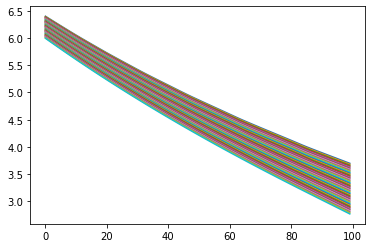

In [5]:
plt.plot(ϕ_i[0])
plt.show()

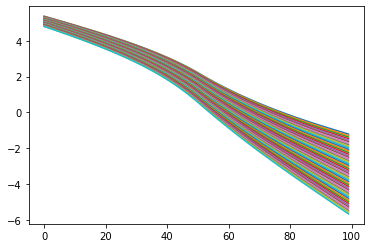

In [6]:
plt.plot(ϕ_i[1])
plt.show()

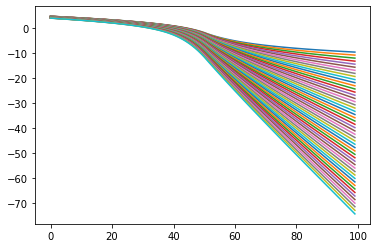

In [7]:
plt.plot(ϕ_i[2])
plt.show()

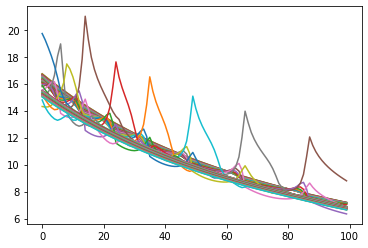

In [8]:
plt.plot(ems_i[0])
plt.show()

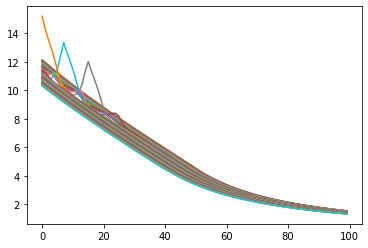

In [9]:
plt.plot(ems_i[1])
plt.show()

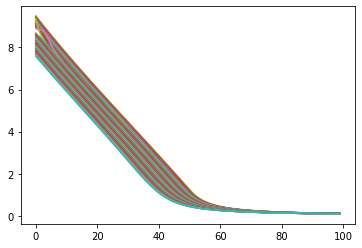

In [10]:
plt.plot(ems_i[2])
plt.show()

In [11]:
def false_transient_robust(y1_grid, y2_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, γ_1, γ_2, πc_o, πd_o, ξ_a, ξ_p, ϕ_i = model_paras
    dy1 = y1_grid[1] - y1_grid[0]
    dy2 = y2_grid[1] - y2_grid[0]
    (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
    stateSpace = np.hstack([y1_mat.reshape(-1, 1, order='F'), y2_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -η*(y1_mat+y2_mat+(y1_mat+y2_mat)**2)

    d_Λ = γ_1 + γ_2*y1_mat

    πd = np.ones((len(πd_o), len(y1_grid), len(y2_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y1_grid), len(y2_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    bc_y = -ξ_p*np.log(np.sum(πd_o[:, -1, :]*np.exp(-1./ξ_p*ϕ_i[:, -1, :]), axis=0))
    bc = (np.zeros(0), bc_y, np.zeros(0), np.zeros(0))
    impose_bc = (False, True, False, False)

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()

        v0_dy1 = compute_derivatives(v0, 0, 1, dy1)
        v0_dy2 = compute_derivatives(v0, 1, 1, dy2)        

        e_tilde = -η/(v0_dy2*λ*np.sum(πc*θ, axis=0))
        e_tilde[e_tilde<=0] = 1e-15

        log_πc_ratio = -v0_dy2*λ*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        A = np.ones_like(y1_mat) * (-δ)
        B1 = y2_mat
        B2 = λ*(-y2_mat+np.sum(πc_o*θ, axis=0)*e_tilde)
        C1 = np.zeros_like(y1_mat)
        C2 = np.zeros_like(y2_mat)
        D = η*np.log(e_tilde) + (η-1)/δ*d_Λ*y2_mat + ξ_a * c_entropy

        v0 = false_transient_one_iteration_python(A, B1, B2, C1, C2, D, v0, ϵ, dy1, dy2, bc, impose_bc) # CG tol = 1e-10

        rhs_error = A*v0 + B1*v0_dy1 + B2*v0_dy2 + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'e_tilde': e_tilde}
    return res

In [12]:
nbar = int(y_bar/y1_step) + 1
ϕ_i_short = np.array([temp[:nbar, :] for temp in ϕ_i])
model_paras = (η, δ, θ, γ_1, γ_2, πc_o, πd_o, ξ_a, ξ_p, ϕ_i_short)
model_res = false_transient_robust(y1_grid_short, y2_grid, model_paras,
                                   v0=np.average(ϕ_i_short, weights=πd_o, axis=0),
                                   ϵ=.3, tol=1e-8, max_iter=1000, print_all=True)

Iteration 1: LHS Error: 14.953470657826719; RHS Error 0.06552461610307991
Iteration 2: LHS Error: 2.646592802403842; RHS Error 3.206108785492226
Iteration 3: LHS Error: 1.8488650597114007; RHS Error 2.233350188715393
Iteration 4: LHS Error: 1.299619434037244; RHS Error 1.5539075461760465
Iteration 5: LHS Error: 1.1291100805369534; RHS Error 1.0762956357415625
Iteration 6: LHS Error: 0.9583042228356575; RHS Error 0.8765259357335542
Iteration 7: LHS Error: 0.7954788506740126; RHS Error 0.7406532152084603
Iteration 8: LHS Error: 0.697485572334274; RHS Error 0.6072848828833743
Iteration 9: LHS Error: 0.6237829028351987; RHS Error 0.49174297496457237
Iteration 10: LHS Error: 0.5486675011185849; RHS Error 0.4370690720213877
Iteration 11: LHS Error: 0.47752167397226764; RHS Error 0.37949310749437515
Iteration 12: LHS Error: 0.43968318035000714; RHS Error 0.3228098662162157
Iteration 13: LHS Error: 0.39932363469403914; RHS Error 0.2718278275973142
Iteration 14: LHS Error: 0.3600715092249759; R

Iteration 113: LHS Error: 0.020634205675928257; RHS Error 0.15011638632685448
Iteration 114: LHS Error: 0.020448240831044316; RHS Error 0.14993113905665617
Iteration 115: LHS Error: 0.02025751603150624; RHS Error 0.14988821901440566
Iteration 116: LHS Error: 0.02018716972967442; RHS Error 0.14983876868443485
Iteration 117: LHS Error: 0.020118942681908912; RHS Error 0.1498503872290468
Iteration 118: LHS Error: 0.02004677922474644; RHS Error 0.1498968971072864
Iteration 119: LHS Error: 0.019970648424885905; RHS Error 0.14987107892568124
Iteration 120: LHS Error: 0.019890581037204463; RHS Error 0.1498967255324366
Iteration 121: LHS Error: 0.019806574013732092; RHS Error 0.14992383117552574
Iteration 122: LHS Error: 0.019718644722404775; RHS Error 0.14992393592398912
Iteration 123: LHS Error: 0.01962677696543791; RHS Error 0.150026874871725
Iteration 124: LHS Error: 0.019531159988973222; RHS Error 0.14985035564876378
Iteration 125: LHS Error: 0.019431653050177765; RHS Error 0.1498873430445

Iteration 221: LHS Error: 0.01201717452360492; RHS Error 0.14979100818009392
Iteration 222: LHS Error: 0.01196457797028631; RHS Error 0.14984998450482412
Iteration 223: LHS Error: 0.011910703541156606; RHS Error 0.1496494706471052
Iteration 224: LHS Error: 0.011855140976515521; RHS Error 0.14970504378273417
Iteration 225: LHS Error: 0.011798036743308298; RHS Error 0.14980849965307494
Iteration 226: LHS Error: 0.01173948661108426; RHS Error 0.1497773278944634
Iteration 227: LHS Error: 0.011679476889618162; RHS Error 0.14976672230379784
Iteration 228: LHS Error: 0.011617965007371112; RHS Error 0.14980512271993324
Iteration 229: LHS Error: 0.011554981933577698; RHS Error 0.14984772587844125
Iteration 230: LHS Error: 0.011505876538110787; RHS Error 0.14988573432861726
Iteration 231: LHS Error: 0.011467448944542843; RHS Error 0.14995837009679736
Iteration 232: LHS Error: 0.01142771880357311; RHS Error 0.14995756152957848
Iteration 233: LHS Error: 0.01138668202671056; RHS Error 0.14998951717

Iteration 329: LHS Error: 0.007733253752488049; RHS Error 0.14996572339271486
Iteration 330: LHS Error: 0.007706911112516461; RHS Error 0.1499779490329871
Iteration 331: LHS Error: 0.00767986010882756; RHS Error 0.14999201765909595
Iteration 332: LHS Error: 0.007652146485481737; RHS Error 0.14991222052535197
Iteration 333: LHS Error: 0.007623677194531868; RHS Error 0.1499575433241115
Iteration 334: LHS Error: 0.007594545381735726; RHS Error 0.14986879713811926
Iteration 335: LHS Error: 0.007564708693313568; RHS Error 0.1498386978107351
Iteration 336: LHS Error: 0.007534170700488711; RHS Error 0.14983800830376784
Iteration 337: LHS Error: 0.007502929532940961; RHS Error 0.14984706492395924
Iteration 338: LHS Error: 0.007470981891620395; RHS Error 0.1498721699063707
Iteration 339: LHS Error: 0.007438417608550315; RHS Error 0.1498720815159142
Iteration 340: LHS Error: 0.007414669501478363; RHS Error 0.14989552067414513
Iteration 341: LHS Error: 0.007390279373979958; RHS Error 0.1498903411

Iteration 436: LHS Error: 0.005237195855665178; RHS Error 0.14999822726033435
Iteration 437: LHS Error: 0.005219554198157006; RHS Error 0.1499348247989047
Iteration 438: LHS Error: 0.005201499801485987; RHS Error 0.14999028206470752
Iteration 439: LHS Error: 0.005183080528775956; RHS Error 0.14992591256501187
Iteration 440: LHS Error: 0.005164233243786972; RHS Error 0.14996720459531399
Iteration 441: LHS Error: 0.005145029198302768; RHS Error 0.14994451272383844
Iteration 442: LHS Error: 0.005125415059185438; RHS Error 0.14987800985634936
Iteration 443: LHS Error: 0.005107368057402084; RHS Error 0.14987571303862762
Iteration 444: LHS Error: 0.005091104927544462; RHS Error 0.14984968056133685
Iteration 445: LHS Error: 0.005074561070192256; RHS Error 0.14990202113439632
Iteration 446: LHS Error: 0.005057518836117936; RHS Error 0.14982049527750946
Iteration 447: LHS Error: 0.0050401285493029135; RHS Error 0.15001133261468674
Iteration 448: LHS Error: 0.0050224342618883835; RHS Error 0.149

Iteration 544: LHS Error: 0.003626056310401064; RHS Error 0.14980246683535337
Iteration 545: LHS Error: 0.00361332191454918; RHS Error 0.14985352511808658
Iteration 546: LHS Error: 0.003600415405813351; RHS Error 0.1498444705368136
Iteration 547: LHS Error: 0.0035876490416401436; RHS Error 0.14982308664506916
Iteration 548: LHS Error: 0.003577595432705157; RHS Error 0.14997380314341335
Iteration 549: LHS Error: 0.0035674064111616373; RHS Error 0.1498908445203047
Iteration 550: LHS Error: 0.003560553884704258; RHS Error 0.15000649038773164
Iteration 551: LHS Error: 0.0035568817027442634; RHS Error 0.14981785134082698
Iteration 552: LHS Error: 0.0035527566370004613; RHS Error 0.14987293746445327
Iteration 553: LHS Error: 0.0035478693560975216; RHS Error 0.1497837034250999
Iteration 554: LHS Error: 0.0035422140399118027; RHS Error 0.1498167176518746
Iteration 555: LHS Error: 0.0035358788241316814; RHS Error 0.1497966381916937
Iteration 556: LHS Error: 0.003528786237838588; RHS Error 0.149

Iteration 652: LHS Error: 0.0023525073149214632; RHS Error 0.14991033421807712
Iteration 653: LHS Error: 0.002335272937144713; RHS Error 0.14999051868954283
Iteration 654: LHS Error: 0.0023182145481026595; RHS Error 0.14999902959747413
Iteration 655: LHS Error: 0.0023005163865708056; RHS Error 0.14988325777111056
Iteration 656: LHS Error: 0.002282947713343475; RHS Error 0.1497845472801395
Iteration 657: LHS Error: 0.0022651760651459796; RHS Error 0.14989836160862807
Iteration 658: LHS Error: 0.002247155728213694; RHS Error 0.14989135230607176
Iteration 659: LHS Error: 0.002229074067825465; RHS Error 0.14988365793911523
Iteration 660: LHS Error: 0.0022109686249294214; RHS Error 0.14997720486394645
Iteration 661: LHS Error: 0.0021925897442069226; RHS Error 0.14977650501339423
Iteration 662: LHS Error: 0.0021741788357587666; RHS Error 0.14981253267428507
Iteration 663: LHS Error: 0.0021555962424250437; RHS Error 0.14989669455337865
Iteration 664: LHS Error: 0.002137155478768212; RHS Error

Iteration 760: LHS Error: 0.000874191381557606; RHS Error 0.14980769683761505
Iteration 761: LHS Error: 0.0007414348694808245; RHS Error 0.14980954230152083
Iteration 762: LHS Error: 0.0006693606486463111; RHS Error 0.14990755345178386
Iteration 763: LHS Error: 0.0009906239934280119; RHS Error 0.14977724649216745
Iteration 764: LHS Error: 0.0005008025460847184; RHS Error 0.14986235385714747
Iteration 765: LHS Error: 0.0005868979380478183; RHS Error 0.14991356069621015
Iteration 766: LHS Error: 0.0011331637158680983; RHS Error 0.14979980521364125
Iteration 767: LHS Error: 0.0007512497057349243; RHS Error 0.1498527699350226
Iteration 768: LHS Error: 0.0014632630496021668; RHS Error 0.14989671292454784
Iteration 769: LHS Error: 0.0006525424764417902; RHS Error 0.14970300439353657
Iteration 770: LHS Error: 0.00046834323895591134; RHS Error 0.14980905936293643
Iteration 771: LHS Error: 0.0004496887366345348; RHS Error 0.14982051606261748
Iteration 772: LHS Error: 0.000679041596254315; RHS E

Iteration 868: LHS Error: 0.0009378397712704138; RHS Error 0.14990035649274186
Iteration 869: LHS Error: 0.0008995164181987055; RHS Error 0.14989397585357173
Iteration 870: LHS Error: 0.0008418866915160805; RHS Error 0.14991051955559737
Iteration 871: LHS Error: 0.0007711170763465466; RHS Error 0.14995614945722768
Iteration 872: LHS Error: 0.0007146050220541156; RHS Error 0.14995101234186492
Iteration 873: LHS Error: 0.0007228765105260493; RHS Error 0.14995974548041394
Iteration 874: LHS Error: 0.000715199688077206; RHS Error 0.14999176819227694
Iteration 875: LHS Error: 0.0006928319735906759; RHS Error 0.14998413489573725
Iteration 876: LHS Error: 0.0006578520564826107; RHS Error 0.14998741885378944
Iteration 877: LHS Error: 0.0006130608508965926; RHS Error 0.14995900368074083
Iteration 878: LHS Error: 0.0005612650872066638; RHS Error 0.14993637940265897
Iteration 879: LHS Error: 0.0005540324215935755; RHS Error 0.14992043422406442
Iteration 880: LHS Error: 0.0005436135748985531; RHS 

Iteration 972: LHS Error: 0.00046682960931650663; RHS Error 0.14997165379906824
Iteration 973: LHS Error: 0.00102133052021595; RHS Error 0.1499596523242178
Iteration 974: LHS Error: 0.0004488429512328196; RHS Error 0.1498398006326251
Iteration 975: LHS Error: 0.0003875412684746967; RHS Error 0.1498282952009682
Iteration 976: LHS Error: 0.0004559313257646025; RHS Error 0.1498799219322854
Iteration 977: LHS Error: 0.0009880626771533822; RHS Error 0.14995871085508808
Iteration 978: LHS Error: 0.0011025020813493214; RHS Error 0.14972905330156536
Iteration 979: LHS Error: 0.0015613700913326887; RHS Error 0.14984956946634925
Iteration 980: LHS Error: 0.00046231957519774863; RHS Error 0.149790722113669
Iteration 981: LHS Error: 0.0004674870542705397; RHS Error 0.14982908965140374
Iteration 982: LHS Error: 0.00021483992697006; RHS Error 0.1499087711857241
Iteration 983: LHS Error: 0.0009396463027696219; RHS Error 0.14991005883087144
Iteration 984: LHS Error: 0.000477772712015323; RHS Error 0.1

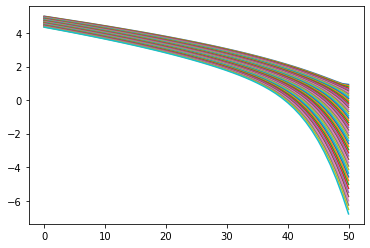

In [13]:
plt.plot(model_res['v0'])

In [14]:
np.save('emission_two_state', model_res['e_tilde'])

In [15]:
ems_i_short = np.array([temp[:nbar, :] for temp in ems_i])
np.save('emission_two_state_low', ems_i[0])
np.save('emission_two_state_high', ems_i[1])
np.save('emission_two_state_extreme', ems_i[2])